In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read, write
import statsmodels.api as sm
import seaborn as sns
from dscribe.descriptors import ACSF, SOAP
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
import math
plt.rc('font', family="sans-serif", weight="bold")          # controls default text sizes
plt.rc('axes', labelsize=20, titlesize=20, labelweight="bold", titleweight="bold")    # x and y axes
plt.rc('xtick', labelsize=20)    # Major Ticks
plt.rc('ytick', labelsize=20)    # Major Ticks
plt.rc('xtick.minor', visible=True)    # Minor Ticks
plt.rc('ytick.minor', visible=True)    # Minor Ticks
plt.rc('legend', fontsize=10)    # Legend
plt.rc('figure', titlesize=10)  # Figure title


plt.rcParams['figure.dpi'] = 300
print(plt.rcParams['font.family'])
torch.cuda.is_available()

['sans-serif']


False

https://medium.com/towards-data-science/building-rnn-lstm-and-gru-for-time-series-using-pytorch-a46e5b094e7b

https://www.kaggle.com/code/andradaolteanu/pytorch-rnns-and-lstms-explained-acc-0-99

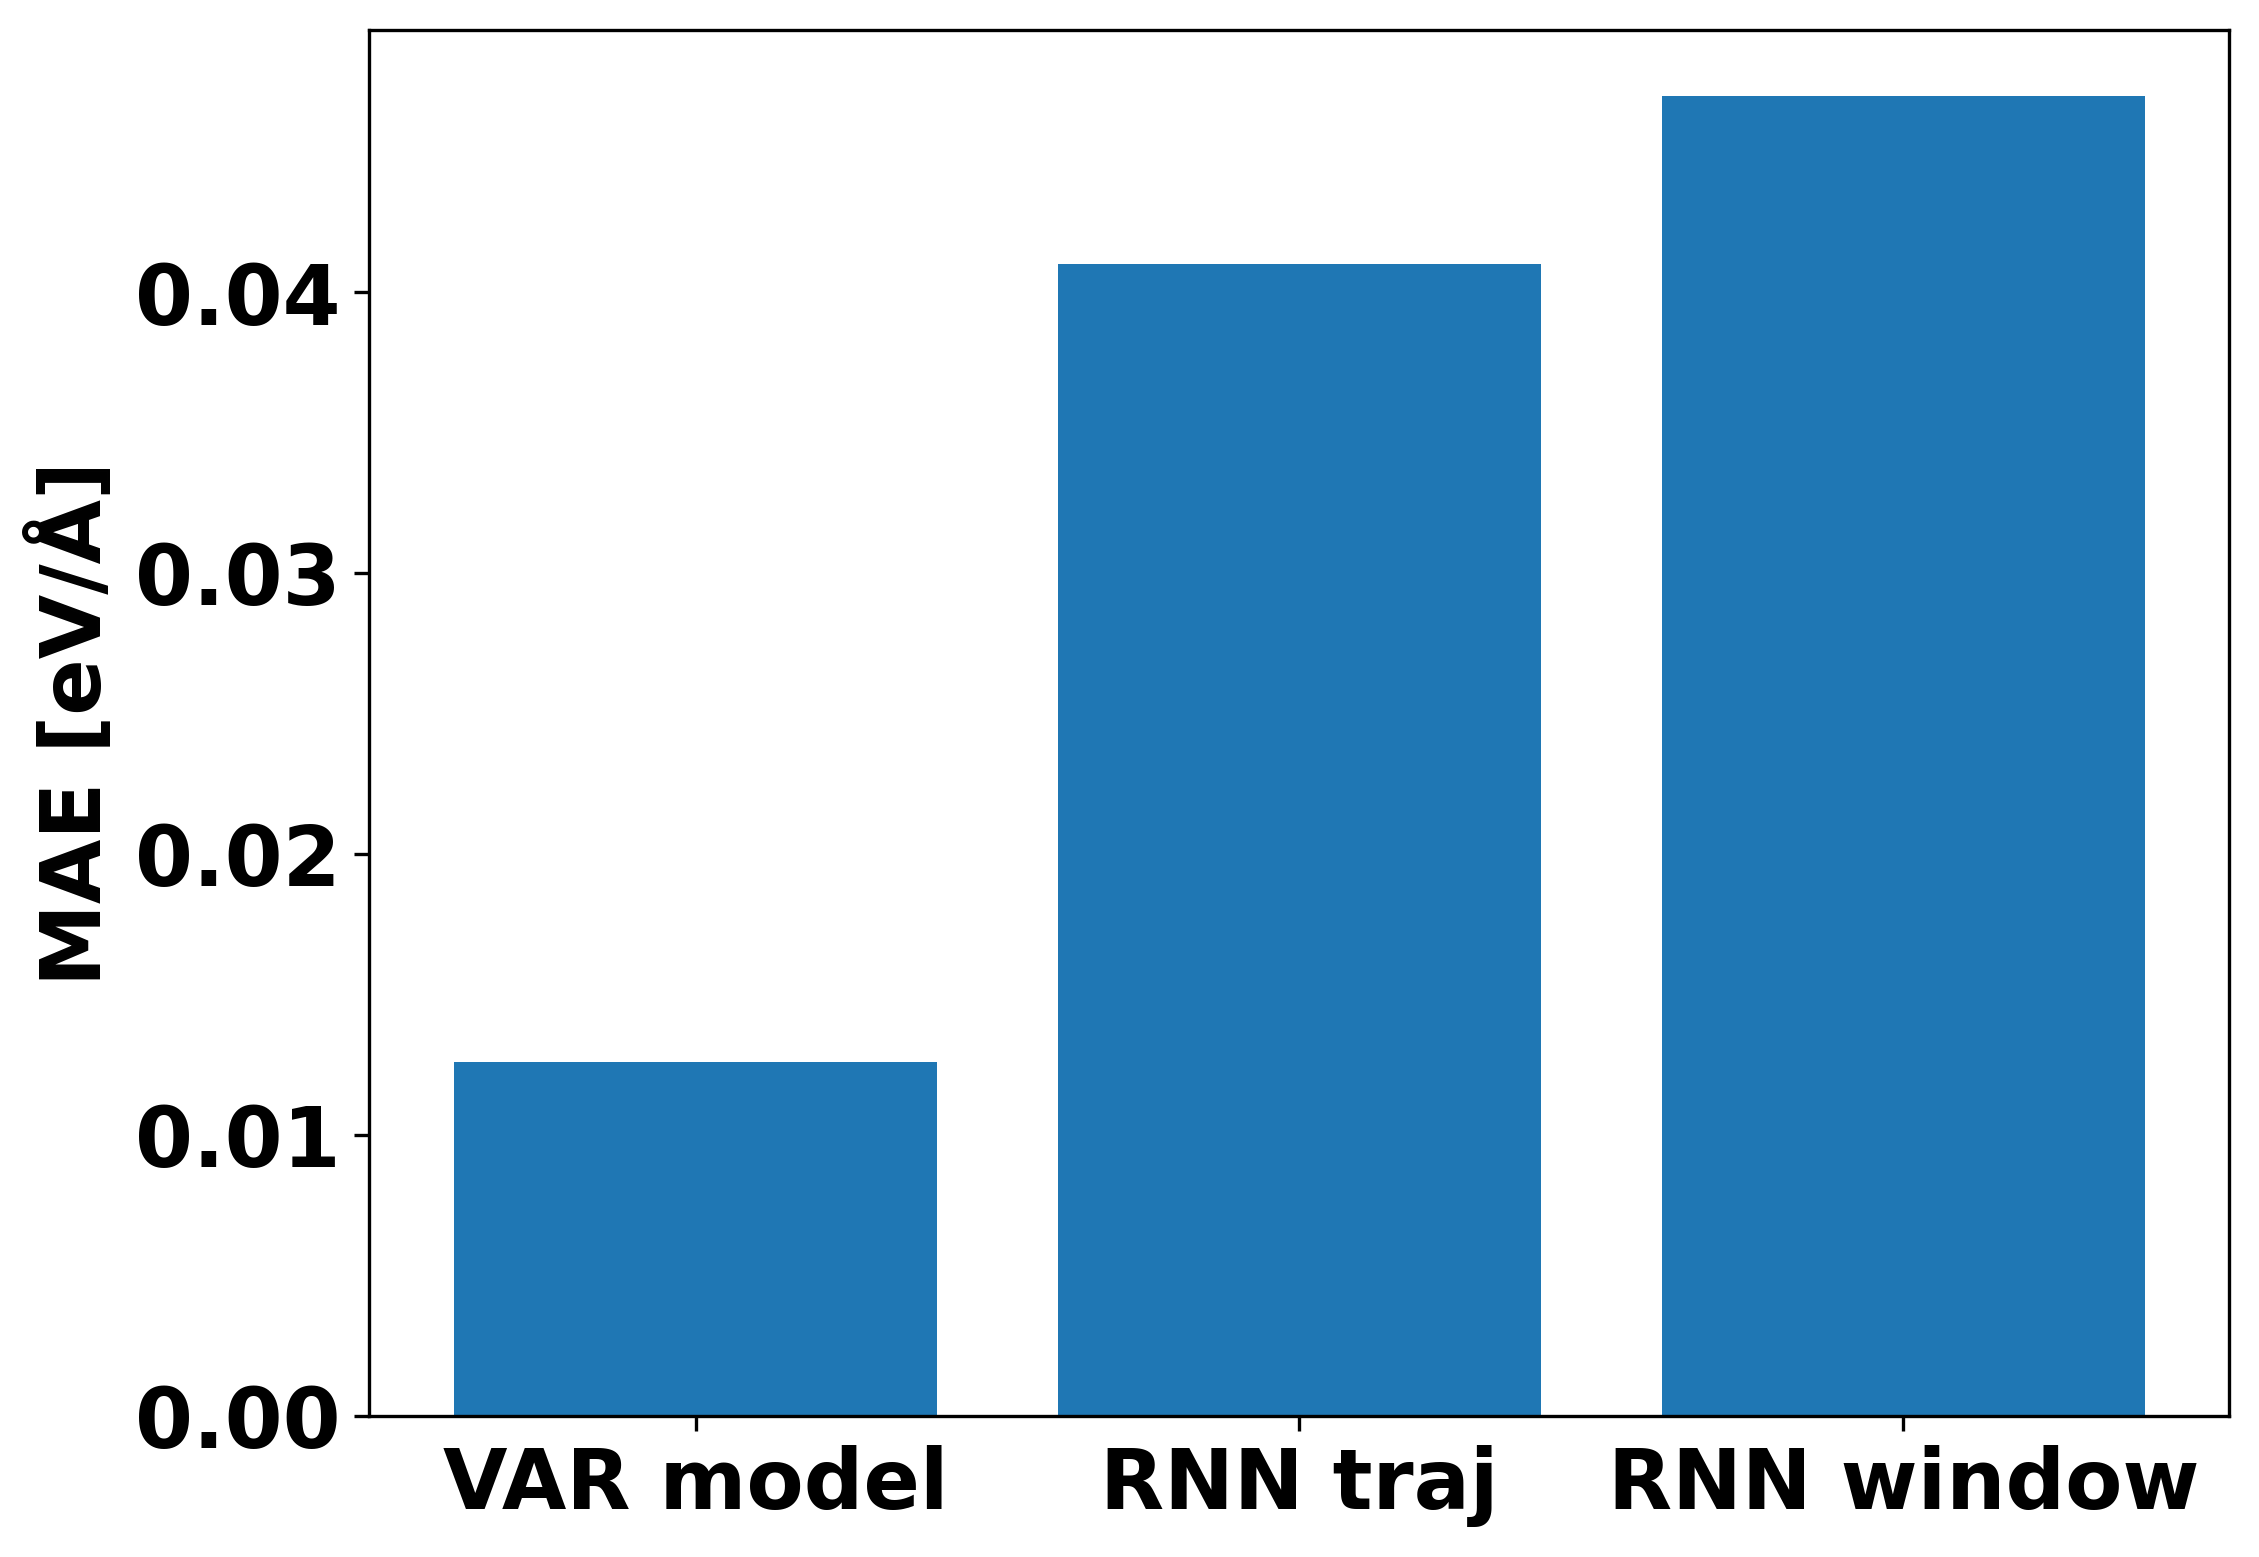

In [87]:
labels = ["VAR model", "RNN traj", "RNN window"]
mae = [0.0126, 0.041, 0.047]
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(range(0, 3), mae[:3])
ax.set_ylabel("MAE [eV/Å]")
ax.set_xticks(range(0, 3), labels[:])
ax.minorticks_off()

# Autocorrelation

(array([2.000e+00, 3.000e+00, 3.000e+00, 1.000e+00, 9.000e+00, 1.000e+00,
        5.000e+00, 4.000e+00, 1.100e+01, 8.000e+00, 2.200e+01, 2.200e+01,
        4.600e+01, 6.300e+01, 9.800e+01, 1.340e+02, 1.390e+02, 1.850e+02,
        2.060e+02, 2.320e+02, 2.550e+02, 3.100e+02, 3.340e+02, 4.820e+02,
        5.250e+02, 6.140e+02, 7.050e+02, 8.130e+02, 8.500e+02, 9.460e+02,
        1.014e+03, 1.087e+03, 1.100e+03, 1.047e+03, 1.018e+03, 1.082e+03,
        9.760e+02, 9.910e+02, 8.640e+02, 8.010e+02, 6.800e+02, 6.310e+02,
        5.900e+02, 5.220e+02, 3.760e+02, 3.290e+02, 3.010e+02, 2.590e+02,
        2.110e+02, 1.590e+02, 1.390e+02, 1.240e+02, 8.000e+01, 7.700e+01,
        6.900e+01, 6.400e+01, 4.300e+01, 3.800e+01, 3.200e+01, 3.200e+01,
        2.800e+01, 1.200e+01, 8.000e+00, 1.700e+01, 1.200e+01, 7.000e+00,
        4.000e+00, 3.000e+00, 3.000e+00, 2.000e+00]),
 array([-3.74053644, -3.63006132, -3.51958619, -3.40911106, -3.29863594,
        -3.18816081, -3.07768569, -2.96721056, -2.85673543,

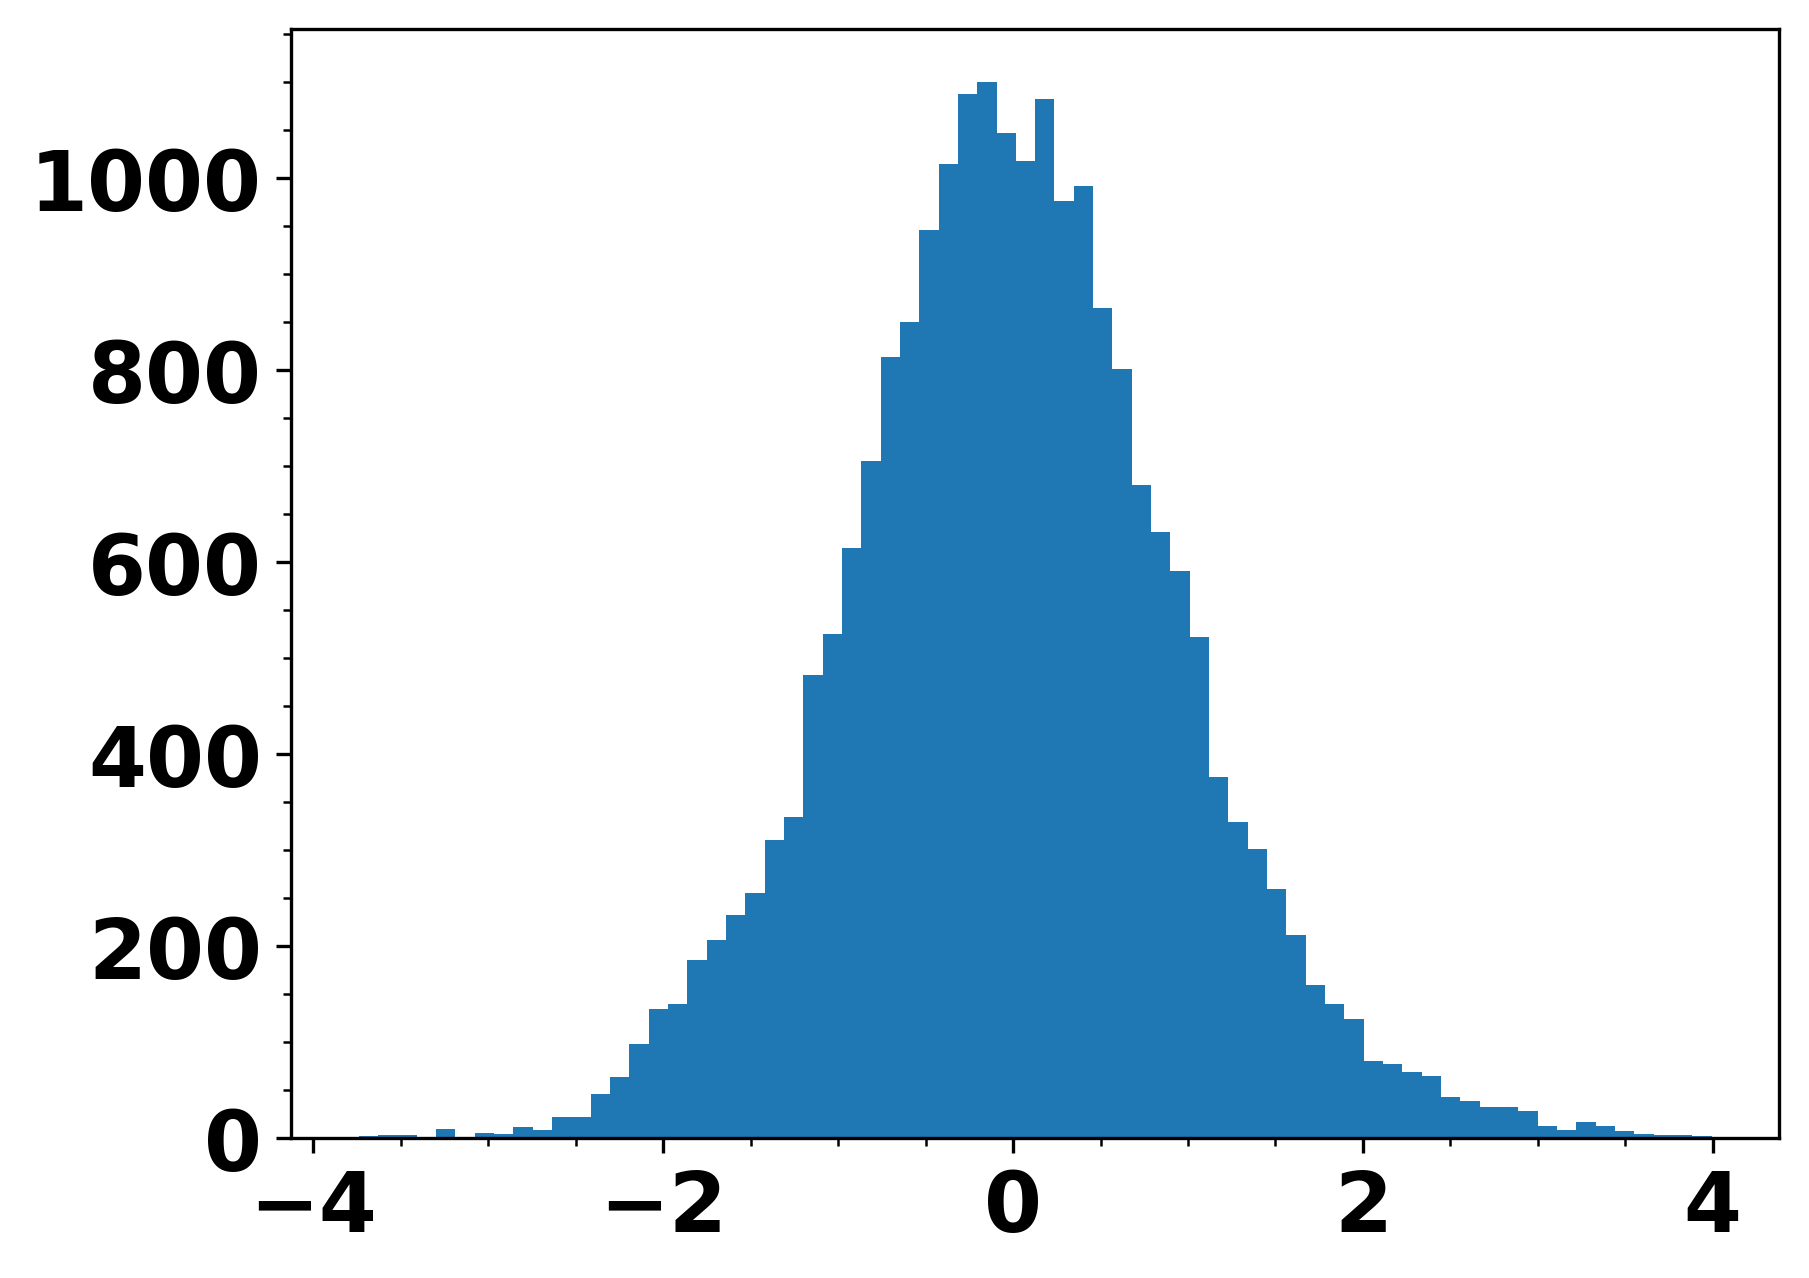

In [3]:
force_df = pd.read_csv("Data/Model_test/Moldyn_dataframe_data.csv")
plt.hist(force_df['H1(x)'], bins=70)

Text(0.5, 1.0, '')

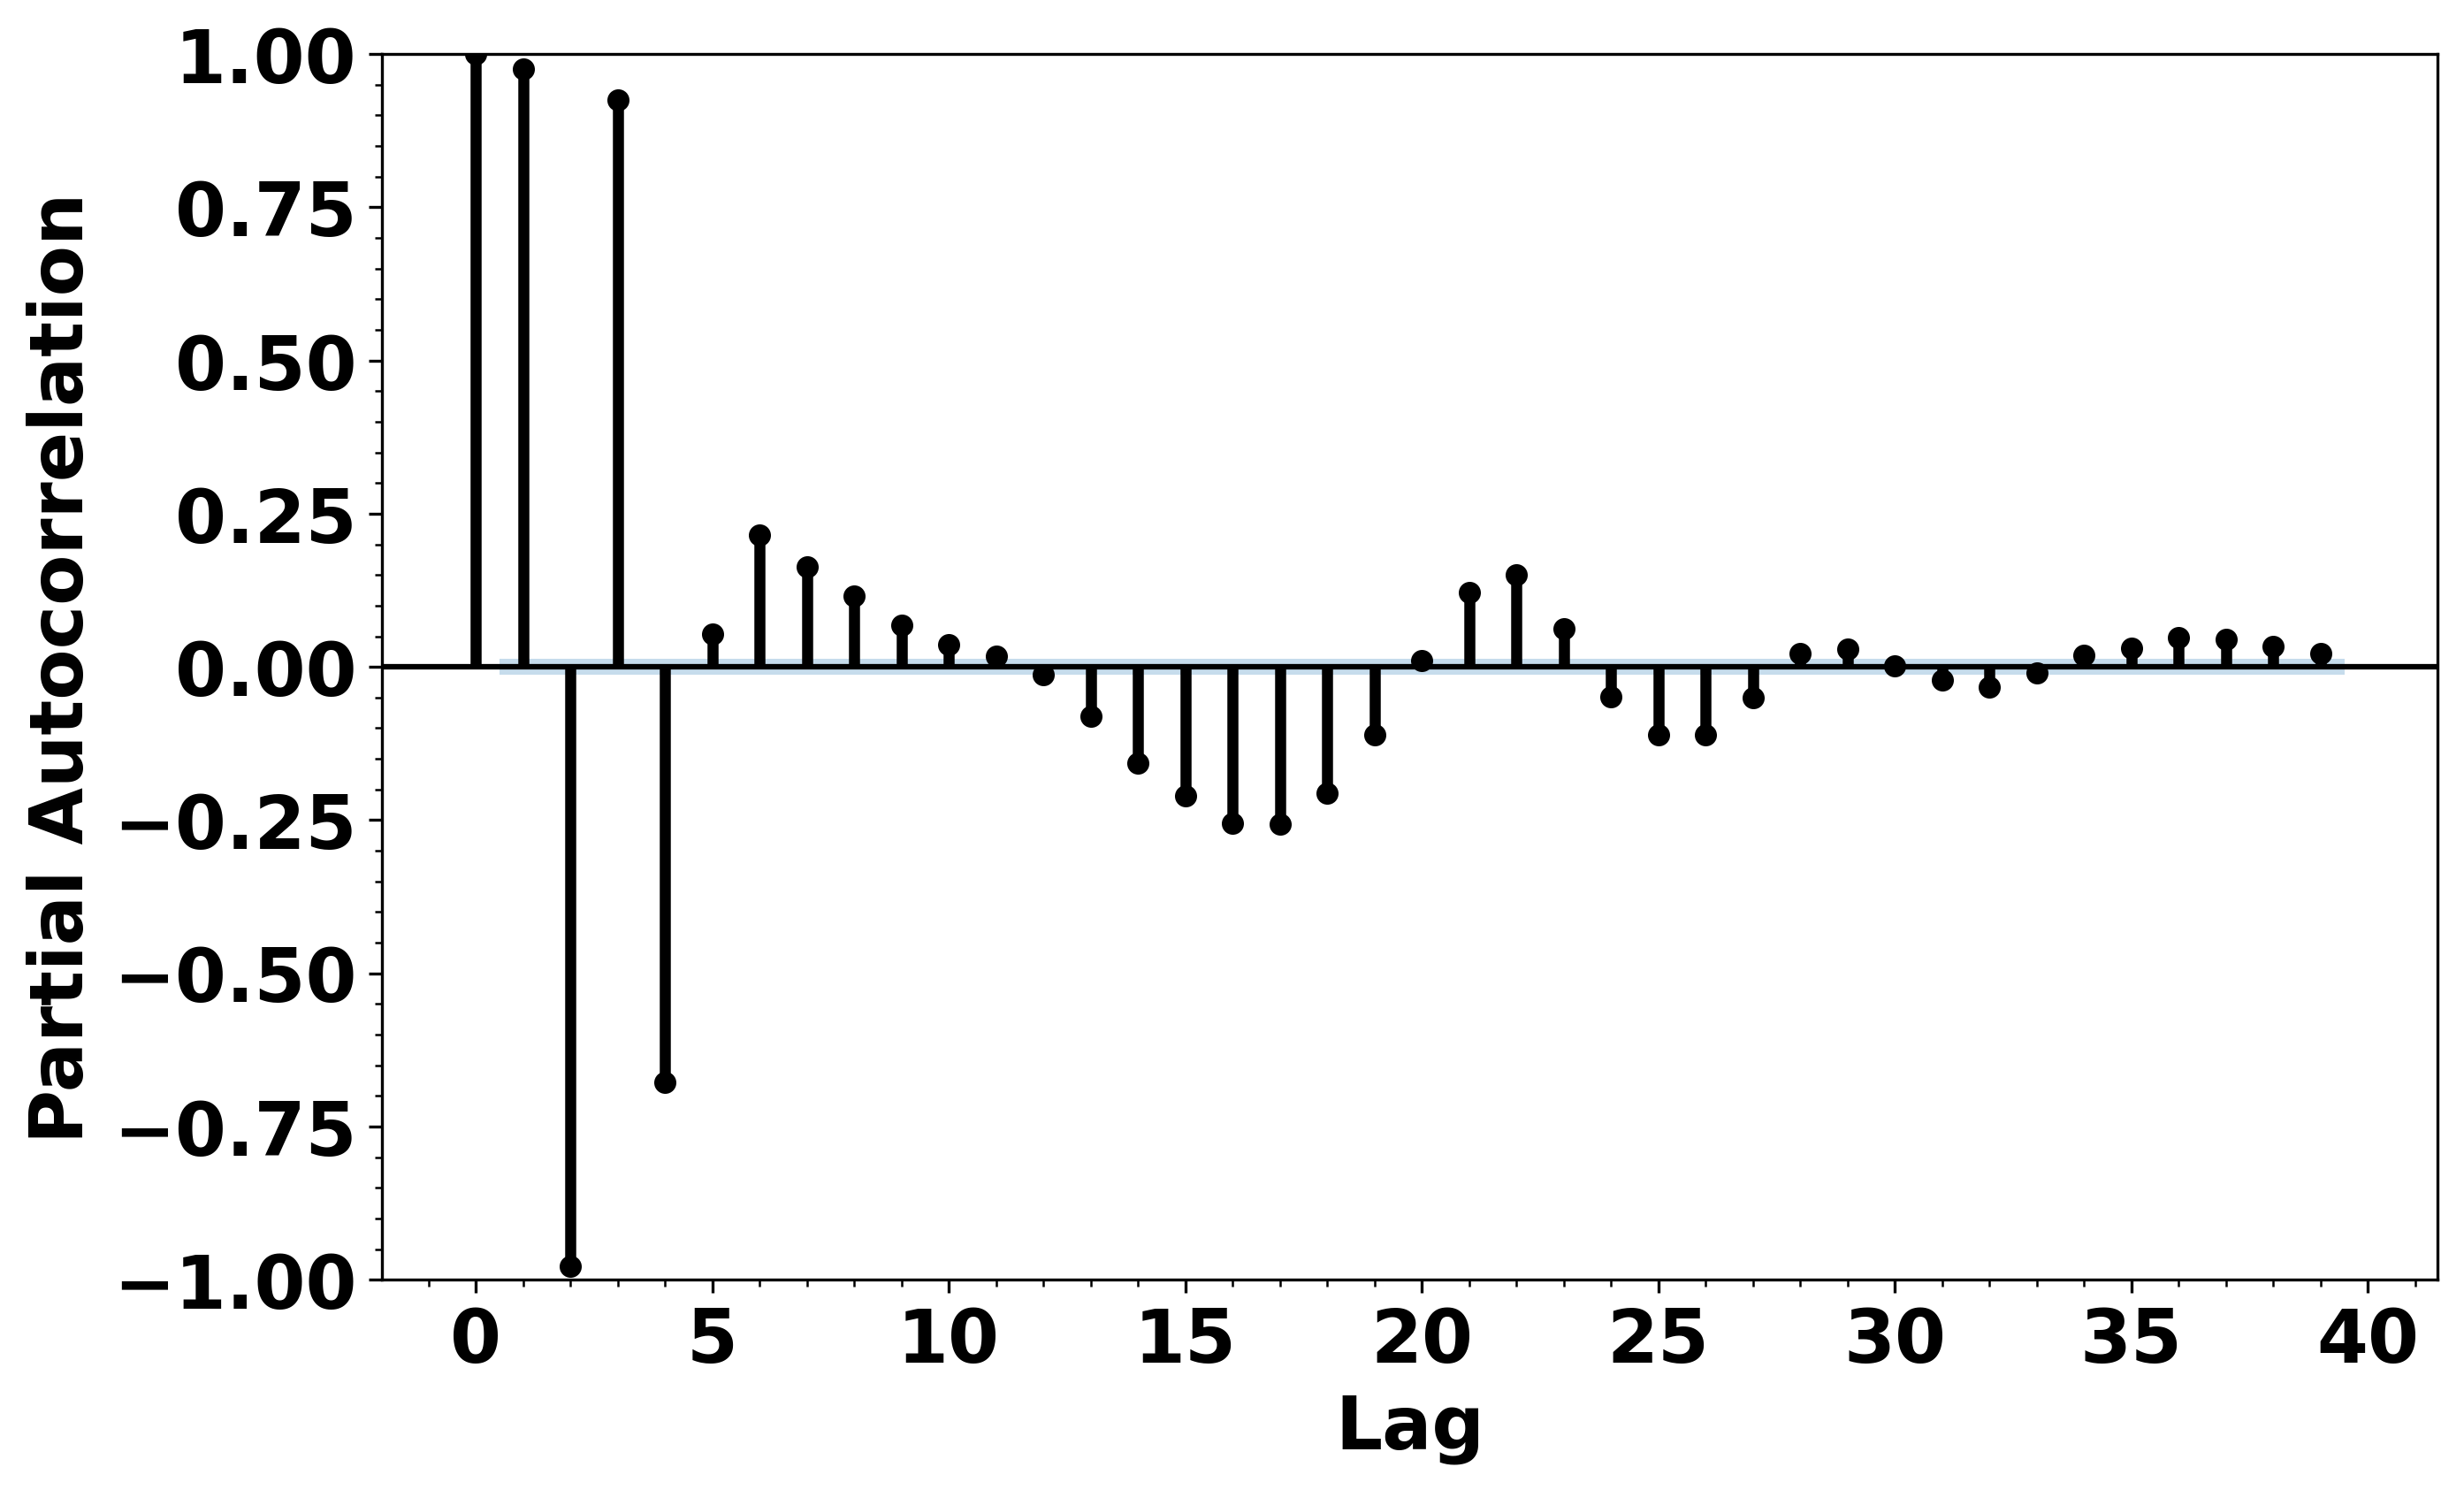

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))
fig = sm.graphics.tsa.plot_pacf(force_df['O(x)'], lags=np.arange(0, 40), ax=ax, markersize=5, color="black", vlines_kwargs={"color":"black", "linewidth": 3})
ax.set_xlabel("Lag")
ax.set_xticks([0, 5, 10, 15, 20, 25, 30, 35, 40])
ax.set_ylabel("Partial Autocorrelation")
ax.set_title("")

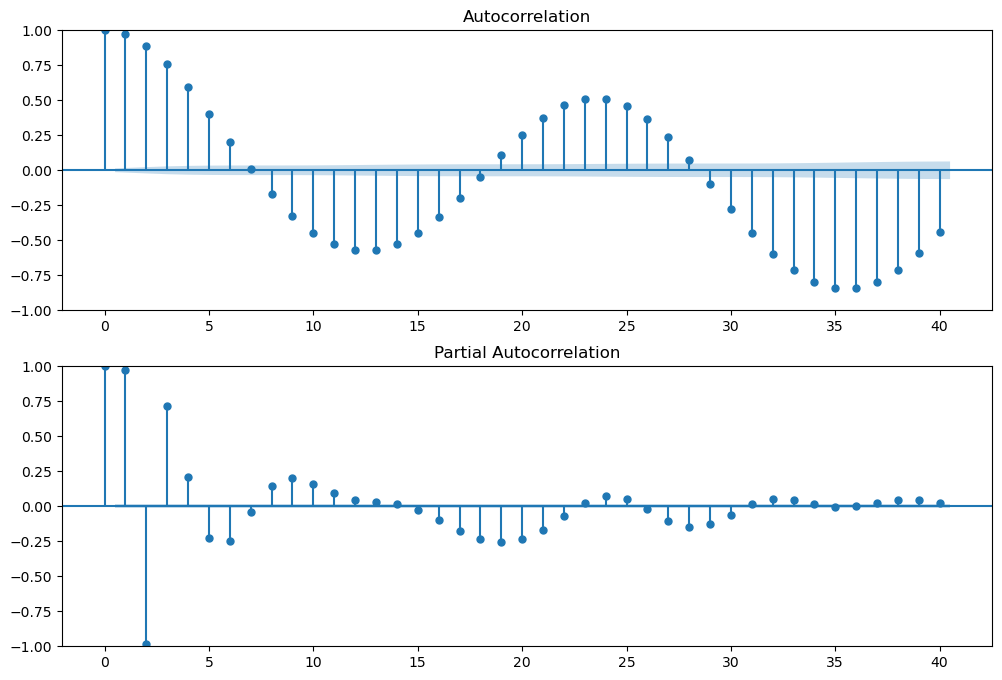

In [16]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(force_df['C1(z)'], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(force_df['C1(z)'], lags=40, ax=ax2)

### There seems to be information in the first 4 timelags

# Create Data

In [2]:
mol = read("Data/Seeds/EtOH_moldyn_data_500.xyz", index=":")

In [3]:
def get_acsf(mol, species=['H', 'C', 'O'], r_cut=6):
    acsf_dscr = ACSF(
        species=species,
        r_cut=r_cut
    )
    ACSF_data = np.zeros((len(mol), mol[0].get_global_number_of_atoms()*acsf_dscr.get_number_of_features()))
    for i in range(len(mol)):
        ACSF_data[i,:] = acsf_dscr.create(mol[i]).flatten()
    return ACSF_data

def get_soap(mol, species=['H', 'C', 'O'], r_cut=6, n_max=8, l_max=6, periodic=False):
    soap_dscr = SOAP(
        species=species,
        periodic=periodic,
        r_cut=r_cut,
        n_max=n_max,
        l_max=l_max
    )
    SOAP_data = np.zeros((len(mol), mol[0].get_global_number_of_atoms()*soap_dscr.get_number_of_features()))
    for i in range(len(mol)):
        SOAP_data[i,:] = soap_dscr.create(mol[i]).flatten()
    return SOAP_data

#Creates a dataset with X and Y values for RNN, dataset[:,:-27] yields the X input data, dataset[:,-27:] yields the target Y data. Replace 27 with n_atoms*3 for general molecules.
def create_dataset(mol, nlags=4, mode="ACSF"):
    if mode == "ACSF":
        dscribe_data = get_acsf(mol)
    elif mode =="SOAP":
        dscribe_data = get_soap(mol)
    else:
        print("Choose a descripter: ACSF or SOAP")
        return
    n_atoms = mol[0].get_global_number_of_atoms()
    n_forces = n_atoms*3
    n_traj = len(mol)
    n_dscribe = dscribe_data.shape[1]

    n_feat = n_forces+n_dscribe
    dataX = np.zeros((n_traj-nlags, nlags, n_feat+n_atoms))
    dataY = np.zeros((n_traj-nlags, n_forces))
    dataset = np.zeros((n_traj, n_feat)) 
    #Create dataset that contains forces and describtor at each timestep
    for i in range(n_traj):
        dataset[i, :n_forces] = mol[i].get_forces().flatten()
        dataset[i, n_forces:] = dscribe_data[i,:]
    
    #Scaling dataset
    scaler_forces = MinMaxScaler(feature_range=(0, 1))
    scaler_dscribe = MinMaxScaler(feature_range=(0, 1))
    dataset[:,:n_forces] = scaler_forces.fit_transform(dataset[:,:n_forces])
    dataset[:,n_forces:] = scaler_dscribe.fit_transform(dataset[:,n_forces:])

    # Creating trainX and trainY
    for i in range(n_traj-nlags):
        dataY[i, :] = dataset[i+nlags, :n_forces]
        for j in range(nlags):
            dataX[i, j, :n_feat] = dataset[i+j, :]
            dataX[i, j, n_feat:] = mol[0].get_atomic_numbers()/mol[0].get_atomic_numbers().max()
    

    
    return dataX, dataY, scaler_forces, scaler_dscribe

dataX, dataY, scaler_forces, scaler_dscribe = create_dataset(mol)
print(dataX.shape, dataY.shape)


(14752, 4, 63) (14752, 27)


In [146]:
joblib.dump(scaler_forces, "EtOH_RNN_scaler_forces.gz")
joblib.dump(scaler_dscribe, "EtOH_RNN_scaler_dscribe.gz")

scaler = joblib.load("EtOH_RNN_scaler.gz")



In [7]:
n_feat = 27*2
n_atoms = 9
print(dataX[4:10,:,0])
print(dataY[:10,0])
print(dataX.min(), dataX.max())

[[0.51051203 0.54447254 0.57641281 0.60337429]
 [0.54447254 0.57641281 0.60337429 0.6238037 ]
 [0.57641281 0.60337429 0.6238037  0.63722105]
 [0.60337429 0.6238037  0.63722105 0.64386248]
 [0.6238037  0.63722105 0.64386248 0.64437311]
 [0.63722105 0.64386248 0.64437311 0.6395864 ]]
[0.51051203 0.54447254 0.57641281 0.60337429 0.6238037  0.63722105
 0.64386248 0.64437311 0.6395864  0.63048932]
0.0 1.0000000000000004


# Testing for outliers

In [114]:
for i in range(n_feat):
    print(dataX[:,0,i].min(), dataX[:,0,i].max())

0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 0.9999999999999998
0.0 0.9999999999999999
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 0.9999999999999999
0.0 0.9999999999999998
0.0 1.0
0.0 1.0
0.0 0.9999999999999999
0.0 0.9999999999999999
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0000000000000004
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 0.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 0.9999999999999999
0.0 1.0
0.0 1.0
0.0 0.9999999999999999
0.0 0.9999999999999996
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0000000000000002
0.0 1.0


-4.12468872 2.90237092


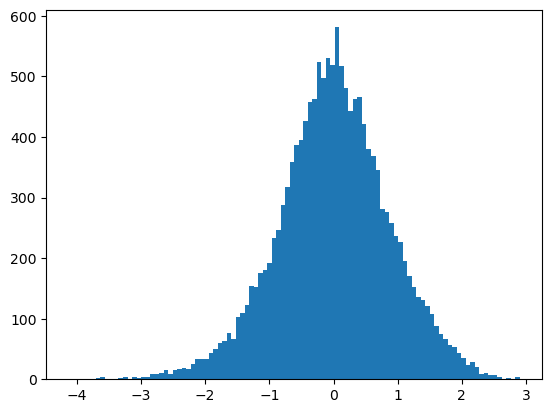

In [11]:
index = 17
print(dataX[:,0,index].min(), dataX[:,0,index].max())
plt.hist(dataX[:,0,index], bins=100)
plt.show()

In [36]:
print(dataX[4,-9:])
print(dataY[0,0])
for i in range(5):
    print(mol[i].get_forces()[0,0])
print(mol[1500].get_distance(0, 1))    

[6. 6. 8. 1. 1. 1. 1. 1. 1.]
0.43158038
-0.47601513
-0.47804957
-0.30412401
0.0177388
0.43158038
1.651156276608


# Model

In [4]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=27):
        super().__init__()
        self.GRU = nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        #self.GRU = nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x, _ = self.GRU(x)  # Run LSTM and store the hidden layer outputs
        x = x[:, -1, :]  # take the last hidden layer
        x = self.linear(x) # a normal dense layer
        return x

class Net_multi(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size=27):
        super().__init__()
        self.GRU1 = nn.GRU(input_size=input_size, hidden_size=hidden_size_1, batch_first=True)
        self.GRU2 = nn.GRU(input_size=hidden_size_1, hidden_size=hidden_size_2, batch_first=True)
        self.linear = nn.Linear(hidden_size_2, output_size)
        
    def forward(self, x):
        x, _ = self.GRU1(x)  # Run LSTM and store the hidden layer outputs
        x, _ = self.GRU2(x)  # Run LSTM and store the hidden layer outputs
        x = x[:, -1, :]  # take the last hidden layer
        x = self.linear(x) # a normal dense layer
        return x

class Net_multi_2(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size=27):
        super().__init__()
        self.GRU1 = nn.GRU(input_size=input_size, hidden_size=hidden_size_1, batch_first=True)
        self.GRU2 = nn.GRU(input_size=hidden_size_1, hidden_size=hidden_size_2, batch_first=True)
        self.GRU3 = nn.GRU(input_size=hidden_size_2, hidden_size=hidden_size_1, batch_first=True)
        self.linear = nn.Linear(hidden_size_1, output_size)
        
    def forward(self, x):
        x, _ = self.GRU1(x)  # Run LSTM and store the hidden layer outputs
        x, _ = self.GRU2(x)  # Run LSTM and store the hidden layer outputs
        x, _ = self.GRU3(x)  # Run LSTM and store the hidden layer outputs
        x = x[:, -1, :]  # take the last hidden layer
        x = self.linear(x) # a normal dense layer
        return x

# Training

In [5]:
dataX, dataY, scaler_forces, scaler_dscribe = create_dataset(mol[:], nlags=40)
print(dataX.shape)

(14716, 40, 63)


In [7]:
np.random.seed(42)

def train_val_test_split(dataX, dataY, test_ratio=0.2):
    val_ratio = test_ratio / (1 - test_ratio)
    trainX, testX, trainY, testY = train_test_split(dataX, dataY, test_size=test_ratio, shuffle=False)
    trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=val_ratio, shuffle=False)
    return trainX, trainY, testX, testY, valX, valY


trainX, trainY, testX, testY, valX, valY = train_val_test_split(dataX, dataY, 0.2)

trainX, trainY = torch.tensor(trainX, dtype=torch.float), torch.tensor(trainY, dtype=torch.float)
testX, testY = torch.tensor(testX, dtype=torch.float), torch.tensor(testY, dtype=torch.float)
valX, valY = torch.tensor(valX, dtype=torch.float), torch.tensor(valY, dtype=torch.float)
print(trainX.shape)
net = Net(trainX.shape[2], 500)

torch.Size([2944, 40, 63])


In [15]:
def train(model, trainX, trainY, valX, valY, n_epochs, lr=5e-3, std_window=5, std_limit=0.5):
    train_loss, val_loss = [], []
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    progress_bar = tqdm(range(n_epochs))
    for epoch in progress_bar:
        train_prediction = model(trainX)
        val_prediction = model(valX)
        loss = torch.sum((train_prediction.flatten() - trainY.flatten())**2)
        train_loss.append(loss.detach().numpy())
        val_loss.append(torch.sum((val_prediction.flatten() - valY.flatten())**2).detach().numpy())
        progress_bar.set_description(f'Loss = {float(loss):6.4f}, Val loss = {float(val_loss[-1]):6.4f}')
        loss.backward()
        opt.step()
        opt.zero_grad()
    print("Converging...")    
    while np.std(val_loss[-std_window:])>std_limit:
        n_epochs+=1
        train_prediction = model(trainX)
        val_prediction = model(valX)
        loss = torch.sum((train_prediction.flatten() - trainY.flatten())**2)
        train_loss.append(loss.detach().numpy())
        progress_bar.set_description(f'Loss = {float(loss):6.4f}, Val loss = {float(val_loss[-1]):6.4f}')
        loss.backward()
        opt.step()
        opt.zero_grad()
        val_loss.append(torch.sum((val_prediction.flatten() - valY.flatten())**2).detach().numpy())
    return train_loss, val_loss, n_epochs

def evaluate(trainX, testX, trainY, testY, model, scaler):
    with torch.no_grad():
        trainPredict = model(trainX).numpy()
        testPredict = model(testX).numpy()
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY_inv = scaler.inverse_transform(trainY.numpy())
    testPredict = scaler.inverse_transform(testPredict)
    testY_inv = scaler.inverse_transform(testY.numpy())

    trainScore = mean_absolute_error(trainY_inv[:], trainPredict[:])
    testScore = mean_absolute_error(testY_inv[:], testPredict[:])

    return trainScore, testScore

In [22]:
np.random.seed(42)
net = Net(trainX.shape[2], 350)
train_loss, val_loss, n_epochs = train(net, trainX, trainY, valX, valY, 2000, std_window=10, std_limit=1)


Loss = 30.4951, Val loss = 12.9535: 100%|██████████| 2000/2000 [3:48:21<00:00,  6.85s/it]   


Converging...


2020
[array(21363.184, dtype=float32), array(3669.1846, dtype=float32), array(14808.673, dtype=float32), array(16405.84, dtype=float32), array(5461.886, dtype=float32), array(7285.56, dtype=float32), array(5716.554, dtype=float32), array(2398.8652, dtype=float32), array(3349.52, dtype=float32), array(3544.6487, dtype=float32), array(2707.9863, dtype=float32), array(2407.938, dtype=float32), array(2136.8845, dtype=float32), array(1818.9888, dtype=float32), array(1861.4094, dtype=float32), array(2007.9677, dtype=float32), array(1852.3776, dtype=float32), array(1555.6785, dtype=float32), array(1453.4817, dtype=float32), array(1532.1632, dtype=float32), array(1568.8828, dtype=float32), array(1505.0568, dtype=float32), array(1435.7515, dtype=float32), array(1390.9386, dtype=float32), array(1342.7684, dtype=float32), array(1304.5417, dtype=float32), array(1298.7362, dtype=float32), array(1306.0079, dtype=float32), array(1295.8989, dtype=float32), array(1268.5142, dtype=float32), array(1240.1

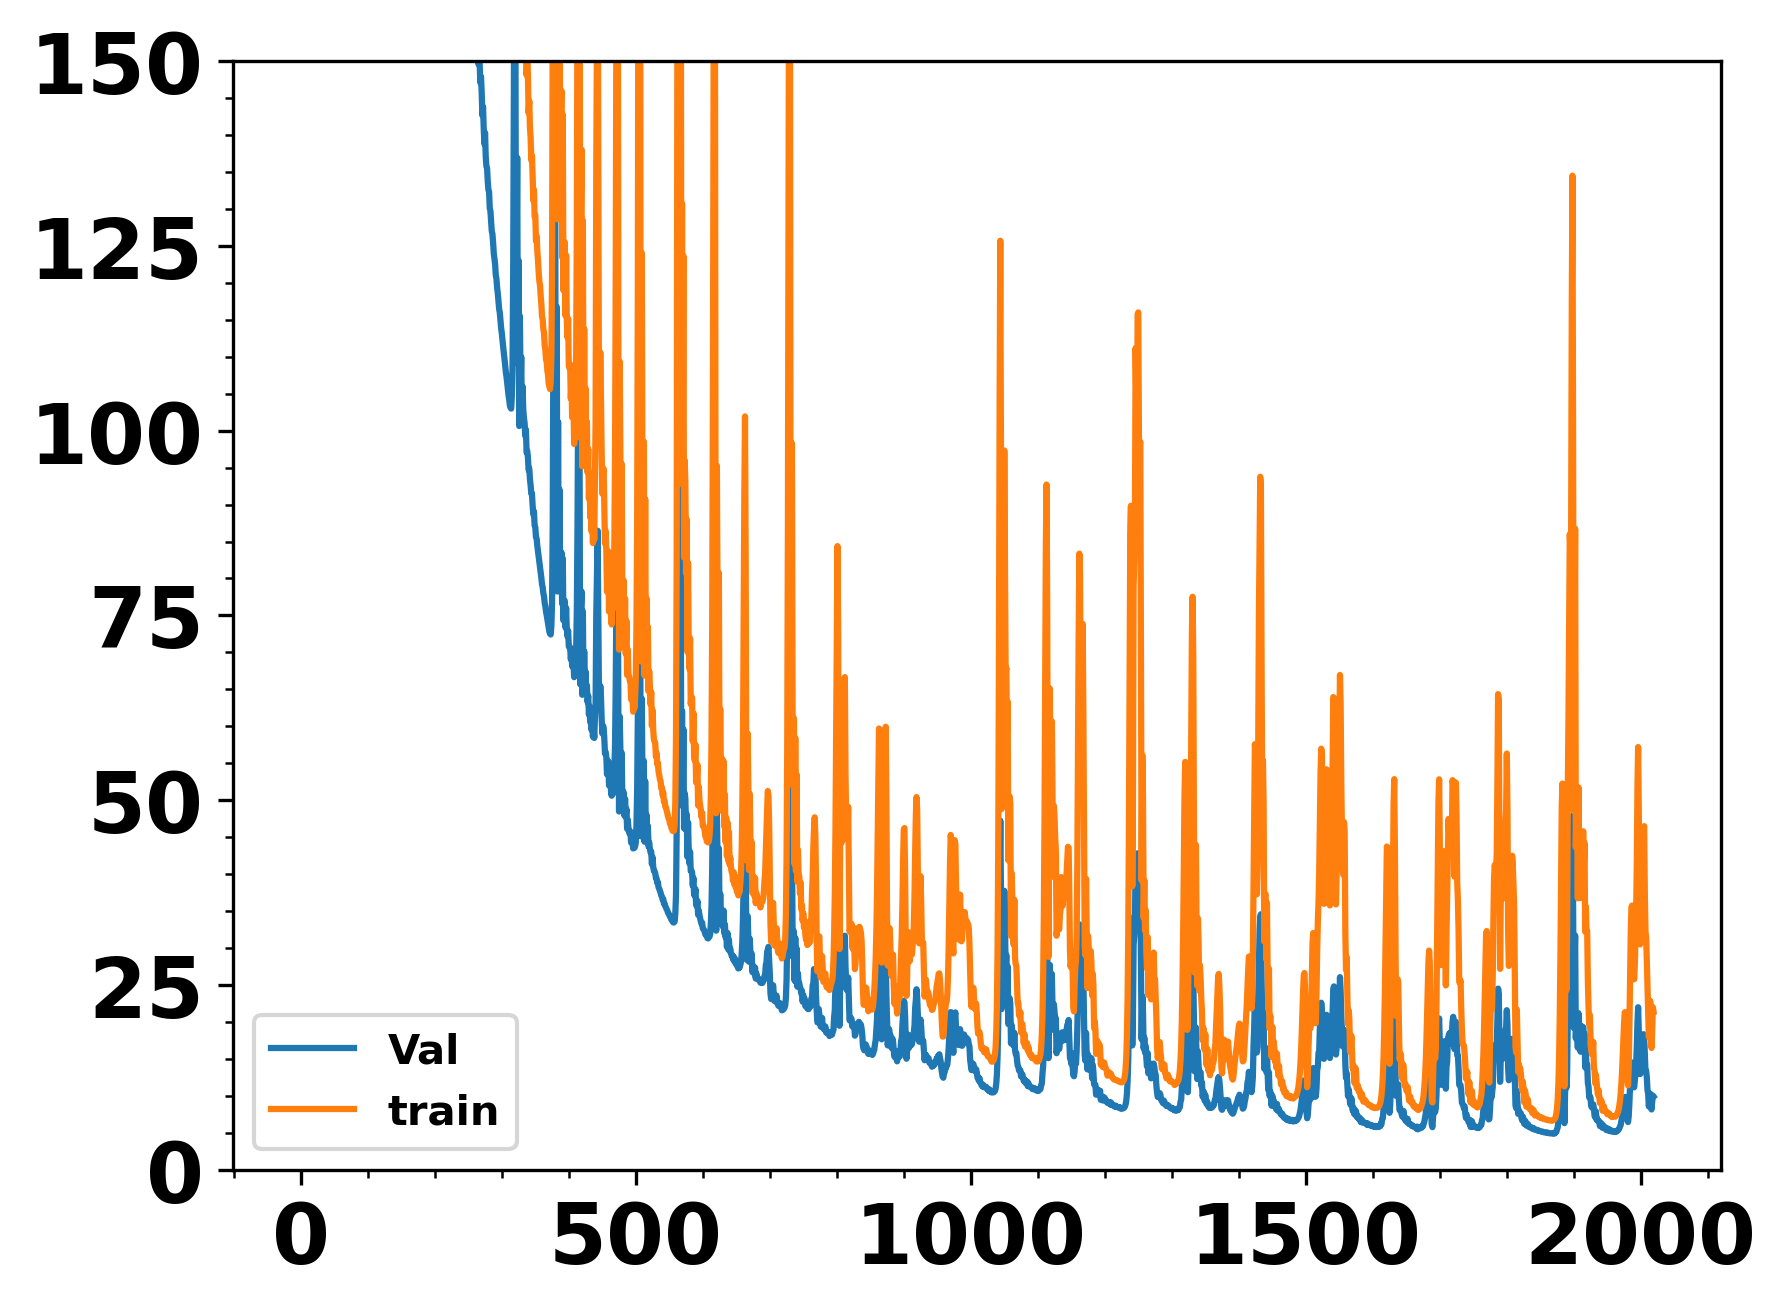

In [23]:
#for i in range(len(train_loss)):
    #train_loss[i] = train_loss[i].detach().numpy()
print(n_epochs)
std_val = []
for i in range(len(val_loss[:-10])+1):
    std_val.append(np.std(val_loss[i:i+5]))
print(val_loss)
print(std_val)
print(np.std(val_loss[-10:]))
plt.plot(range(n_epochs), val_loss, label="Val")
plt.plot(range(n_epochs), train_loss, label="train")
plt.legend()
plt.ylim(0, 150)
plt.show()


In [49]:
np.random.seed(42)
net_2 = Net_multi(trainX.shape[2], 200, 200)
train_loss_2, val_loss_2, n_epochs_2 = train(net_2, trainX, trainY, valX, valY, 2000, std_window=10, std_limit=0.1)

Loss = 31.1611, Val loss = 21.1207: 100%|██████████| 2000/2000 [16:32<00:00,  2.01it/s]   


Converging...


2134
[array(21631.861, dtype=float32), array(5405.829, dtype=float32), array(32477.004, dtype=float32), array(1989.3757, dtype=float32), array(11402.306, dtype=float32), array(10480.85, dtype=float32), array(5936.663, dtype=float32), array(2323.7769, dtype=float32), array(2073.3748, dtype=float32), array(3400.1953, dtype=float32), array(2594.368, dtype=float32), array(1722.9307, dtype=float32), array(2026.8506, dtype=float32), array(2511.0771, dtype=float32), array(2406.62, dtype=float32), array(1942.2217, dtype=float32), array(1665.8198, dtype=float32), array(1732.9635, dtype=float32), array(1839.163, dtype=float32), array(1749.1149, dtype=float32), array(1577.6155, dtype=float32), array(1504.7982, dtype=float32), array(1535.9174, dtype=float32), array(1569.4913, dtype=float32), array(1541.9711, dtype=float32), array(1475.4143, dtype=float32), array(1426.7587, dtype=float32), array(1418.5714, dtype=float32), array(1424.3939, dtype=float32), array(1411.6533, dtype=float32), array(1381.

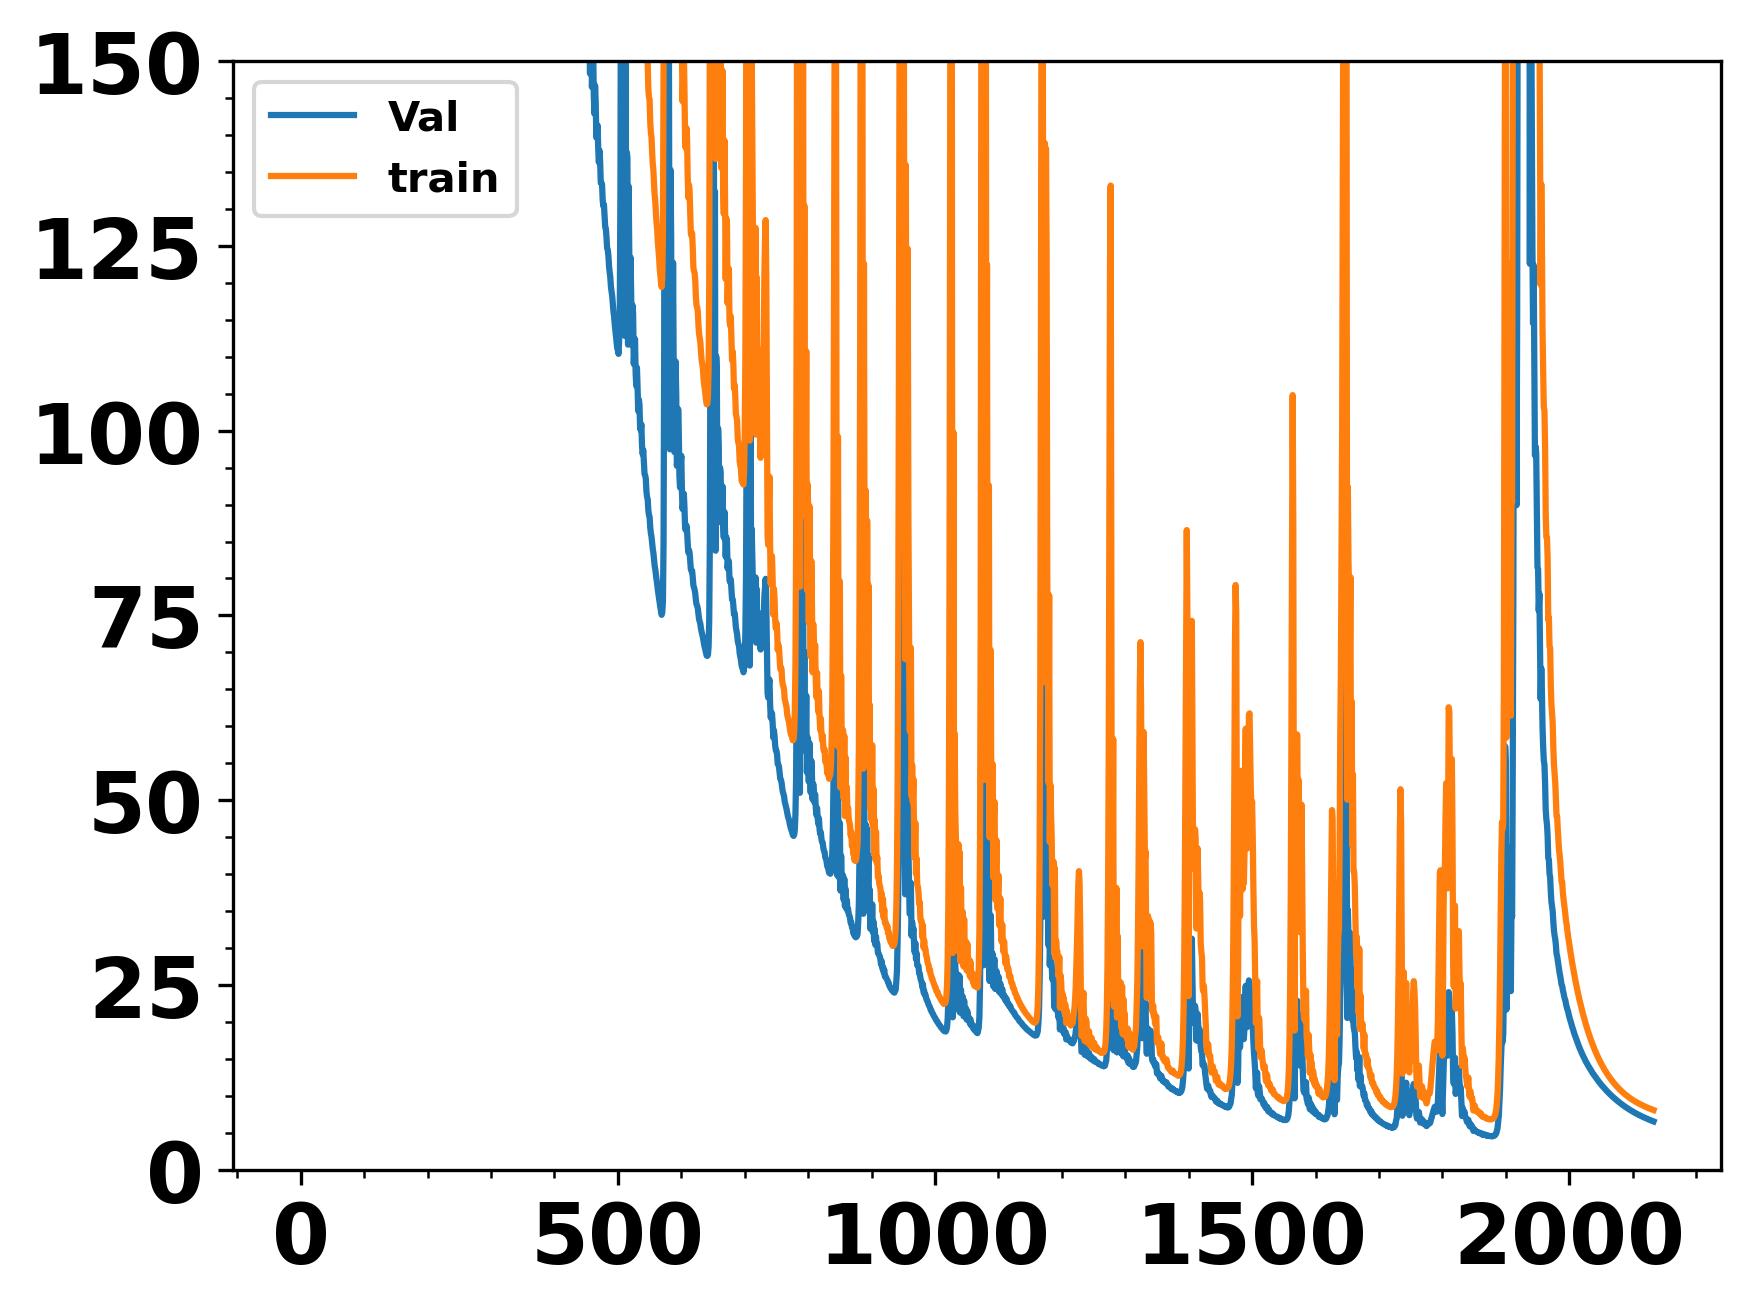

In [50]:
#for i in range(len(train_loss)):
    #train_loss[i] = train_loss[i].detach().numpy()
print(n_epochs_2)
std_val = []
for i in range(len(val_loss_2[:-10])+1):
    std_val.append(np.std(val_loss_2[i:i+5]))
print(val_loss_2)
print(std_val)
print(np.std(val_loss_2[-10:]))
plt.plot(range(n_epochs_2), val_loss_2, label="Val")
plt.plot(range(n_epochs_2), train_loss_2, label="train")
plt.legend()
plt.ylim(0, 150)
plt.show()

In [48]:
np.random.seed(42)
net_3 = Net_multi_2(trainX.shape[2], 200, 200)
train_loss_3, val_loss_3, n_epochs_3 = train(net_3, trainX, trainY, valX, valY, 2000, std_window=10, std_limit=0.1)

Loss = 5176.2148, Val loss = 1718.0491:   1%|          | 16/2000 [00:12<25:23,  1.30it/s]  


KeyboardInterrupt: 

2194
[array(21300.61, dtype=float32), array(3762.6365, dtype=float32), array(20373.516, dtype=float32), array(17315.266, dtype=float32), array(139667.73, dtype=float32), array(26131.957, dtype=float32), array(13562.51, dtype=float32), array(14366.739, dtype=float32), array(3816.8335, dtype=float32), array(2897.981, dtype=float32), array(4489.8096, dtype=float32), array(1678.6136, dtype=float32), array(4739.1416, dtype=float32), array(4339.5303, dtype=float32), array(1724.4131, dtype=float32), array(2546.7432, dtype=float32), array(1665.1914, dtype=float32), array(2099.3047, dtype=float32), array(2181.222, dtype=float32), array(1445.3345, dtype=float32), array(1834.9546, dtype=float32), array(1787.1711, dtype=float32), array(1462.2256, dtype=float32), array(1678.7949, dtype=float32), array(1601.438, dtype=float32), array(1413.3091, dtype=float32), array(1573.1704, dtype=float32), array(1521.448, dtype=float32), array(1371.3167, dtype=float32), array(1482.3304, dtype=float32), array(1467

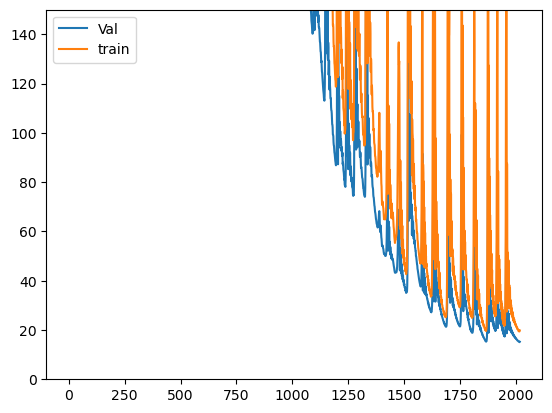

In [28]:
#for i in range(len(train_loss)):
    #train_loss[i] = train_loss[i].detach().numpy()
print(n_epochs)
std_val = []
for i in range(len(val_loss_3[:-10])+1):
    std_val.append(np.std(val_loss_3[i:i+5]))
print(val_loss_3)
print(std_val)
print(np.std(val_loss_3[-10:]))
plt.plot(range(n_epochs_3), val_loss_3, label="Val")
plt.plot(range(n_epochs_3), train_loss_3, label="train")
plt.legend()
plt.ylim(0, 150)
plt.show()

# Testing

In [24]:
# Make predictions:
with torch.no_grad():
    trainPredict = net(trainX).numpy()
    testPredict = net(testX).numpy()

# Invert predictions:
trainPredict = scaler_forces.inverse_transform(trainPredict)
trainY_inv = scaler_forces.inverse_transform(trainY.numpy())
testPredict = scaler_forces.inverse_transform(testPredict)
testY_inv = scaler_forces.inverse_transform(testY.numpy())

print(trainY_inv.shape, trainPredict.shape)
# Calculate root mean squared error:
trainScore = mean_absolute_error(trainY_inv[:], trainPredict[:])
print('Train Score: %.4f MAE' % (trainScore))
testScore = mean_absolute_error(testY_inv[:], testPredict[:])
print('Test Score: %.4f MAE' % (testScore))

# # Shift train predictions for plotting:
# trainPredictPlot = np.empty_like(dataset)
# trainPredictPlot[:, :] = np.nan
# trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# # Shift test predictions for plotting:
# testPredictPlot = np.empty_like(dataset)
# testPredictPlot[:, :] = np.nan
# testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# # Plot baseline and predictions:
# plt.plot(scaler.inverse_transform(dataset), label="Data")
# plt.plot(trainPredictPlot, label="Training predictions")
# plt.plot(testPredictPlot, label="Testing predictions")
# plt.legend()
# plt.show()

(8829, 27) (8829, 27)
Train Score: 0.0711 MAE
Test Score: 0.0761 MAE


# Optimizing

### Learning Rate

In [8]:
#lr = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1]
lr = [ 1e-1, 5e-1, 1]
train_score, test_score = [0.93584126, 0.6821814, 0.4421704, 0.20443362, 0.13231692, 0.10017839, 0.45785955, 0.85787827], [0.90933967, 0.6902648, 0.4623245, 0.2298662, 0.15288928, 0.11639515, 0.47815818, 0.8579115]
np.random.seed(42)
trainX, trainY, testX, testY, valX, valY = train_val_test_split(dataX, dataY, 0.2)
trainX, trainY = torch.tensor(trainX, dtype=torch.float), torch.tensor(trainY, dtype=torch.float)
testX, testY = torch.tensor(testX, dtype=torch.float), torch.tensor(testY, dtype=torch.float)
valX, valY = torch.tensor(valX, dtype=torch.float), torch.tensor(valY, dtype=torch.float)
for lr in lr:
    print(lr)
    np.random.seed(42)
    net = Net(trainX.shape[2], 500)
    train(net, trainX, trainY, valX, valY, 800, lr=lr)
    trainScore, testScore = evaluate(trainX, testX, trainY, testY, net, scaler_forces)
    train_score.append(trainScore)
    test_score.append(testScore)
    

0.0005


Loss = 192.1188, Val loss = 127.7099: 100%|██████████| 800/800 [13:24<00:00,  1.01s/it]  


0.001


Loss = 88.3871, Val loss = 66.3332: 100%|██████████| 800/800 [13:23<00:00,  1.00s/it]    


0.005


Loss = 48.3304, Val loss = 35.6796: 100%|██████████| 800/800 [13:17<00:00,  1.00it/s]    


0.01


Loss = 1441.3789, Val loss = 605.1440: 100%|██████████| 800/800 [13:50<00:00,  1.04s/it]   


0.05


Loss = 3369.7817, Val loss = 1153.6707: 100%|██████████| 800/800 [21:06<00:00,  1.58s/it]       


0.1


Loss = 8852.3945, Val loss = 2951.3838:   4%|▍         | 35/800 [01:20<29:21,  2.30s/it]       


KeyboardInterrupt: 

# One layer RNN

In [37]:
hidden_size = np.linspace(100, 500, 9)

#hidden_size = [731.57894737, 857.89473684, 984.21052632, 1110.52631579, 1236.84210526, 1363.15789474, 1489.47368421, 1615.78947368, 1742.10526316, 1868.42105263, 1994.73684211, 2121.05263158, 2247.36842105, 2373.68421053, 2500]
print(hidden_size)
#scores from previous optimizing:
#train_score, test_score = [0.13490115, 0.12854068, 0.117309004, 0.12466, 0.12772328], [0.15349995, 0.14712949, 0.13772324, 0.14050506, 0.14510073]
train_score = [0.13623334, 0.10511829, 0.13318735, 0.13280481, 0.13493845, 0.08113236, 0.11933294, 0.12023126, 0.12401973, 0.1234043, 0.13330556, 0.13566418, 0.16238253, 0.14318454, 0.16071187, 0.17270154]
test_score = [0.15777254, 0.12006016, 0.14897205, 0.15069412, 0.15545884, 0.09615651, 0.13606252, 0.13792327, 0.14070477, 0.14346646, 0.15181905, 0.1529496, 0.18150996, 0.1630921, 0.18088032, 0.19397238]
np.random.seed(42)
trainX, trainY, testX, testY, valX, valY = train_val_test_split(dataX, dataY, 0.2)
trainX, trainY = torch.tensor(trainX, dtype=torch.float), torch.tensor(trainY, dtype=torch.float)
testX, testY = torch.tensor(testX, dtype=torch.float), torch.tensor(testY, dtype=torch.float)
valX, valY = torch.tensor(valX, dtype=torch.float), torch.tensor(valY, dtype=torch.float)
for hiddenSize in hidden_size:
    print(hiddenSize)
    np.random.seed(42)
    net = Net(trainX.shape[2], int(hiddenSize))
    train(net, trainX, trainY, valX, valY, 600)
    trainScore, testScore = evaluate(trainX, testX, trainY, testY, net, scaler_forces)
    train_score.append(trainScore)
    test_score.append(testScore)
    

[100. 150. 200. 250. 300. 350. 400. 450. 500.]
100.0


Loss = 122.1189, Val loss = 78.9410: 100%|██████████| 600/600 [01:02<00:00,  9.61it/s]   


Converging...
150.0


Loss = 102.4851, Val loss = 65.9002: 100%|██████████| 600/600 [01:38<00:00,  6.10it/s]   


Converging...
200.0


Loss = 427.5427, Val loss = 175.4388: 100%|██████████| 600/600 [02:13<00:00,  4.50it/s]  


Converging...
250.0


Loss = 173.5839, Val loss = 92.6981: 100%|██████████| 600/600 [03:00<00:00,  3.32it/s]   


Converging...
300.0


Loss = 100.6329, Val loss = 65.0088: 100%|██████████| 600/600 [03:46<00:00,  2.65it/s]   


Converging...
350.0


Loss = 126.8084, Val loss = 77.8474: 100%|██████████| 600/600 [05:09<00:00,  1.94it/s]   


Converging...
400.0


Loss = 192.7203, Val loss = 94.3394: 100%|██████████| 600/600 [05:52<00:00,  1.70it/s]   


Converging...
450.0


Loss = 166.1474, Val loss = 89.1879: 100%|██████████| 600/600 [06:45<00:00,  1.48it/s]   


Converging...
500.0


Loss = 80.3387, Val loss = 52.9643: 100%|██████████| 600/600 [07:41<00:00,  1.30it/s]    


Converging...


In [38]:
print(train_score)
print(test_score)

[0.13623334, 0.10511829, 0.13318735, 0.13280481, 0.13493845, 0.08113236, 0.11933294, 0.12023126, 0.12401973, 0.1234043, 0.13330556, 0.13566418, 0.16238253, 0.14318454, 0.16071187, 0.17270154, 0.15731655, 0.1319519, 0.12883703, 0.1388269, 0.14468181, 0.14408493, 0.13050145, 0.14598373, 0.12546821]
[0.15777254, 0.12006016, 0.14897205, 0.15069412, 0.15545884, 0.09615651, 0.13606252, 0.13792327, 0.14070477, 0.14346646, 0.15181905, 0.1529496, 0.18150996, 0.1630921, 0.18088032, 0.19397238, 0.17693132, 0.15027882, 0.15058744, 0.15853427, 0.16346252, 0.1604244, 0.14851543, 0.16242412, 0.14123298]


# Multilayer RNN

In [42]:

hidden_size = np.linspace(200, 700, 5)

print(hidden_size)

train_score = [[0.4006336, 0.4242438, 0.7158311, 0.5074379, 0.80091476],
 [0.5232693,  0.37818682, 0.68608165, 0.6464745,  0.86538833],
 [0.45692196, 0.43751162, 0.5213792,  0.55184853, 0.63078415],
 [0.46762112, 0.65302545, 0.5929553,  0.5185653,  0.66195226],
 [0.8078115,  0.9192337,  0.9021542,  0.9098312,  0.7238181 ]]
test_score = []
np.random.seed(42)
trainX, trainY, testX, testY, valX, valY = train_val_test_split(dataX, dataY, 0.2)
trainX, trainY = torch.tensor(trainX, dtype=torch.float), torch.tensor(trainY, dtype=torch.float)
testX, testY = torch.tensor(testX, dtype=torch.float), torch.tensor(testY, dtype=torch.float)
valX, valY = torch.tensor(valX, dtype=torch.float), torch.tensor(valY, dtype=torch.float)
for hiddenSize1 in hidden_size:
    for hiddenSize2 in hidden_size:
        print(hiddenSize2)
        np.random.seed(42)
        net = Net_multi(trainX.shape[2], int(hiddenSize1), int(hiddenSize2))
        train(net, trainX, trainY, valX, valY, 200, std_limit=2, std_window=3)
        trainScore, testScore = evaluate(trainX, testX, trainY, testY, net, scaler_forces)
        train_score.append(trainScore)
        test_score.append(testScore)
    

[200. 325. 450. 575. 700.]
200.0


Loss = 1010.4720, Val loss = 471.5418: 100%|██████████| 200/200 [01:36<00:00,  2.06it/s] 


Converging...
325.0


Loss = 1964.9392, Val loss = 794.6568: 100%|██████████| 200/200 [02:20<00:00,  1.42it/s]   


Converging...
450.0


Loss = 3047.4434, Val loss = 1083.1001: 100%|██████████| 200/200 [03:11<00:00,  1.04it/s]  


Converging...
575.0


Loss = 2683.6272, Val loss = 1019.9945: 100%|██████████| 200/200 [04:10<00:00,  1.25s/it]   


Converging...
700.0


Loss = 3366.2585, Val loss = 1160.4969: 100%|██████████| 200/200 [05:16<00:00,  1.58s/it]   


Converging...
200.0


Loss = 1210.1476, Val loss = 535.5856: 100%|██████████| 200/200 [02:31<00:00,  1.32it/s] 


Converging...
325.0


Loss = 2301.2861, Val loss = 879.5396: 100%|██████████| 200/200 [03:24<00:00,  1.02s/it]   


Converging...
450.0


Loss = 1831.5387, Val loss = 748.1476: 100%|██████████| 200/200 [04:41<00:00,  1.41s/it]   


Converging...
575.0


Loss = 2530.8357, Val loss = 946.2866: 100%|██████████| 200/200 [05:27<00:00,  1.64s/it]  


Converging...
700.0


Loss = 1979.1880, Val loss = 810.7974: 100%|██████████| 200/200 [06:28<00:00,  1.94s/it]  


Converging...
200.0


Loss = 1691.7660, Val loss = 705.8152: 100%|██████████| 200/200 [03:16<00:00,  1.02it/s] 


Converging...
325.0


Loss = 2361.8337, Val loss = 918.9187: 100%|██████████| 200/200 [04:11<00:00,  1.26s/it]  


Converging...
450.0


Loss = 2038.4459, Val loss = 813.6451: 100%|██████████| 200/200 [05:10<00:00,  1.55s/it]  


Converging...
575.0


Loss = 2479.9822, Val loss = 930.7872: 100%|██████████| 200/200 [06:25<00:00,  1.93s/it]  


Converging...
700.0


Loss = 2455.4365, Val loss = 937.7598: 100%|██████████| 200/200 [07:50<00:00,  2.35s/it]   


Converging...
200.0


Loss = 2159.6470, Val loss = 839.5015: 100%|██████████| 200/200 [04:43<00:00,  1.42s/it]  


Converging...
325.0


Loss = 6168.0742, Val loss = 2207.8291: 100%|██████████| 200/200 [05:32<00:00,  1.66s/it] 


Converging...
450.0


Loss = 3272.7510, Val loss = 1162.7921: 100%|██████████| 200/200 [06:13<00:00,  1.87s/it] 


Converging...
575.0


Loss = 2844.6304, Val loss = 1017.6414: 100%|██████████| 200/200 [07:34<00:00,  2.27s/it]  


Converging...
700.0


Loss = 3041.2124, Val loss = 1073.9015: 100%|██████████| 200/200 [08:58<00:00,  2.69s/it]   


Converging...
200.0


Loss = 7458.9619, Val loss = 2615.7886:  79%|███████▉  | 158/200 [04:14<01:07,  1.61s/it] 


KeyboardInterrupt: 

In [45]:
print(test_score)
print(np.asarray(train_score).reshape(5,4))

print(np.asarray(test_score).reshape(5,4))

[0.37424657, 0.5713675, 0.69676775, 0.6010075, 0.8449318, 0.4080311, 0.68086725, 0.58062595, 0.6219025, 0.44514444, 0.5549813, 0.56631994, 0.5858523, 0.5936417, 0.6006027, 0.6757602, 0.68953943, 0.78688073, 0.76969475, 0.8732635]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (25,) + inhomogeneous part.

In [31]:
train_score_arr = [[0.4006336, 0.4242438, 0.7158311, 0.5074379, 0.80091476],
 [0.5232693,  0.37818682, 0.68608165, 0.6464745,  0.86538833],
 [0.45692196, 0.43751162, 0.5213792,  0.55184853, 0.63078415],
 [0.46762112, 0.65302545, 0.5929553,  0.5185653,  0.66195226],
 [0.8078115,  0.9192337,  0.9021542,  0.9098312,  0.7238181 ]]
test_score_arr = [[0.43170726, 0.451493, 0.7214546, 0.52497417, 0.79468155],
 [0.5375091, 0.40717483, 0.6940548,  0.66214436, 0.8570649 ],
 [0.48447716, 0.45146024, 0.54343665, 0.57077247, 0.64960665],
 [0.48951092, 0.65728897, 0.60487837, 0.5401247, 0.67321026],
 [0.8048934, 0.90753365, 0.8917614, 0.8977588, 0.7294001 ]]
net = Net_multi((trainX.shape[2], 325, 325))

# Window RNN

In [19]:
mol = read("Data/Seeds/EtOH_moldyn_data_500.xyz", index="25:38")
dataX, dataY, scaler_forces, scaler_dscribe = create_dataset(mol)
print(len((mol)))
print(dataY.shape)

13
(9, 27)


In [20]:
trainX, trainY = dataX[:8,:,:], dataY[:8,:]
testX, testY = dataX[8:,:,:], dataY[8:,:]
print(trainX.shape, testX.shape)
trainX, trainY = torch.tensor(trainX, dtype=torch.float), torch.tensor(trainY, dtype=torch.float)
testX, testY = torch.tensor(testX, dtype=torch.float), torch.tensor(testY, dtype=torch.float)
np.random.seed(42)
net = Net(trainX.shape[2], 450)
train_loss, val_loss, n_epochs = train(net, trainX, trainY, trainX, trainY, 100, std_window=10, std_limit=0.1)

(8, 4, 63) (1, 4, 63)


Loss = 0.0034, Val loss = 0.0034: 100%|██████████| 100/100 [00:00<00:00, 141.51it/s]

Converging...


100
tensor([[0.7935, 0.7128, 0.7693, 0.0000, 0.3398, 0.1480, 1.0000, 0.0285, 0.6366,
         0.9114, 0.1005, 0.8855, 0.0887, 0.9519, 0.8991, 0.0186, 0.0172, 0.0135,
         0.9206, 0.9984, 1.0000, 0.0670, 0.8853, 0.1927, 0.7180, 0.8107, 0.2435]])
[array(119.63135, dtype=float32), array(18.689518, dtype=float32), array(58.257202, dtype=float32), array(30.249733, dtype=float32), array(27.049757, dtype=float32), array(14.711544, dtype=float32), array(10.702237, dtype=float32), array(11.577589, dtype=float32), array(6.4478006, dtype=float32), array(6.547146, dtype=float32), array(7.3872185, dtype=float32), array(5.0188513, dtype=float32), array(4.0931, dtype=float32), array(4.586961, dtype=float32), array(3.8257897, dtype=float32), array(2.619958, dtype=float32), array(2.7841506, dtype=float32), array(3.3844395, dtype=float32), array(2.8746915, dtype=float32), array(2.0269759, dtype=float32), array(1.9336517, dtype=float32), array(2.1180973, dtype=float32), array(1.8441073, dtype=float32

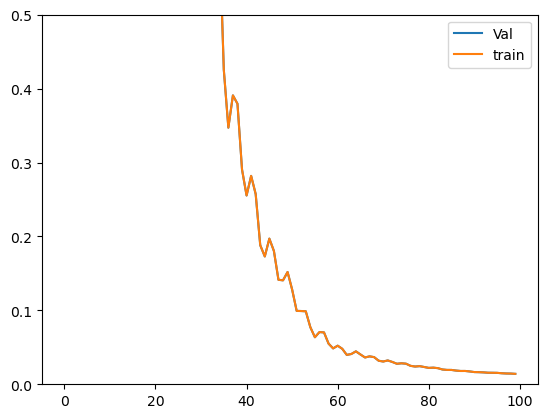

In [66]:
print(n_epochs)
print(testY)
std_val = []
for i in range(len(val_loss[:-10])+1):
    std_val.append(np.std(val_loss[i:i+5]))
print(val_loss)
print(std_val)
print(np.std(val_loss[-10:]))
plt.plot(range(n_epochs), val_loss, label="Val")
plt.plot(range(n_epochs), train_loss, label="train")
plt.legend()
plt.ylim(0, 0.5)
plt.show()

In [82]:
# Make predictions:
with torch.no_grad():
    trainPredict = net(trainX).numpy()
    testPredict = net(testX).numpy()

# Invert predictions:
trainPredict = scaler_forces.inverse_transform(trainPredict)
trainY_inv = scaler_forces.inverse_transform(trainY.numpy())
testPredict = scaler_forces.inverse_transform(testPredict)
testY_inv = scaler_forces.inverse_transform(testY.numpy())

print(trainY_inv.shape, trainPredict.shape)
# Calculate root mean squared error:
trainScore = mean_absolute_error(trainY_inv[:], trainPredict[:])
print('Train Score: %.4f MAE' % (trainScore))
testScore = mean_absolute_error(testY_inv[:], testPredict[:])
print('Test Score: %.4f MAE' % (testScore))

(5, 27) (5, 27)
Train Score: 0.0076 MAE
Test Score: 0.0241 MAE


In [24]:
n_tests = 300
test_mae = []
train_mae = []
for i in range(n_tests):
    mol = read("Data/Seeds/EtOH_moldyn_data_500.xyz", index=slice(i*10,(i+1)*10))
    dataX, dataY, scaler_forces, scaler_dscribe = create_dataset(mol, nlags=4)
    trainX, trainY = dataX[:5,:,:], dataY[:5,:]
    testX, testY = dataX[5:,:,:], dataY[5:,:]
    trainX, trainY = torch.tensor(trainX, dtype=torch.float), torch.tensor(trainY, dtype=torch.float)
    testX, testY = torch.tensor(testX, dtype=torch.float), torch.tensor(testY, dtype=torch.float)
    
    np.random.seed(42)
    net = Net(trainX.shape[2], 450)
    train_loss, val_loss, n_epochs = train(net, trainX, trainY, trainX, trainY, 100, std_window=10, std_limit=0.001)
    with torch.no_grad():
        trainPredict = net(trainX).numpy()
        testPredict = net(testX).numpy()
    
    trainPredict = scaler_forces.inverse_transform(trainPredict)
    trainY_inv = scaler_forces.inverse_transform(trainY.numpy())
    testPredict = scaler_forces.inverse_transform(testPredict)
    testY_inv = scaler_forces.inverse_transform(testY.numpy())

    train_mae.append(mean_absolute_error(trainY_inv[:], trainPredict[:]))
    test_mae.append(mean_absolute_error(testY_inv[:], testPredict[:]))


print("test mae", np.sum(test_mae)/n_tests)
print("train mae", np.sum(train_mae)/n_tests)





Loss = 0.0062, Val loss = 0.0062: 100%|██████████| 100/100 [00:00<00:00, 129.37it/s]


Converging...


Loss = 0.0012, Val loss = 0.0012: 100%|██████████| 100/100 [00:00<00:00, 140.35it/s]


Converging...


Loss = 0.0016, Val loss = 0.0016: 100%|██████████| 100/100 [00:00<00:00, 126.51it/s]


Converging...


Loss = 0.0076, Val loss = 0.0076: 100%|██████████| 100/100 [00:00<00:00, 146.62it/s]


Converging...


Loss = 0.0056, Val loss = 0.0056: 100%|██████████| 100/100 [00:00<00:00, 131.35it/s]


Converging...


Loss = 0.0027, Val loss = 0.0027: 100%|██████████| 100/100 [00:00<00:00, 140.79it/s]


Converging...


Loss = 0.0026, Val loss = 0.0026: 100%|██████████| 100/100 [00:00<00:00, 150.44it/s]


Converging...


Loss = 0.0035, Val loss = 0.0035: 100%|██████████| 100/100 [00:00<00:00, 146.14it/s]


Converging...


Loss = 0.0345, Val loss = 0.0345: 100%|██████████| 100/100 [00:00<00:00, 139.80it/s]


Converging...


Loss = 0.0038, Val loss = 0.0038: 100%|██████████| 100/100 [00:00<00:00, 145.19it/s]


Converging...


Loss = 0.0090, Val loss = 0.0090: 100%|██████████| 100/100 [00:00<00:00, 140.63it/s]


Converging...


Loss = 0.0119, Val loss = 0.0119: 100%|██████████| 100/100 [00:00<00:00, 134.91it/s]


Converging...


Loss = 0.0022, Val loss = 0.0022: 100%|██████████| 100/100 [00:00<00:00, 141.15it/s]


Converging...


Loss = 0.0037, Val loss = 0.0037: 100%|██████████| 100/100 [00:00<00:00, 140.10it/s]


Converging...


Loss = 0.0083, Val loss = 0.0083: 100%|██████████| 100/100 [00:00<00:00, 131.81it/s]


Converging...


Loss = 0.0018, Val loss = 0.0018: 100%|██████████| 100/100 [00:00<00:00, 142.17it/s]


Converging...


Loss = 0.0018, Val loss = 0.0018: 100%|██████████| 100/100 [00:00<00:00, 141.35it/s]


Converging...


Loss = 0.0041, Val loss = 0.0041: 100%|██████████| 100/100 [00:00<00:00, 137.70it/s]


Converging...


Loss = 0.0034, Val loss = 0.0034: 100%|██████████| 100/100 [00:00<00:00, 142.98it/s]


Converging...


Loss = 0.0036, Val loss = 0.0036: 100%|██████████| 100/100 [00:00<00:00, 138.55it/s]


Converging...


Loss = 0.0070, Val loss = 0.0070: 100%|██████████| 100/100 [00:00<00:00, 145.89it/s]


Converging...


Loss = 0.0041, Val loss = 0.0041: 100%|██████████| 100/100 [00:00<00:00, 142.79it/s]


Converging...


Loss = 0.0049, Val loss = 0.0049: 100%|██████████| 100/100 [00:00<00:00, 136.09it/s]


Converging...


Loss = 0.0021, Val loss = 0.0021: 100%|██████████| 100/100 [00:00<00:00, 134.91it/s]


Converging...


Loss = 0.0038, Val loss = 0.0038: 100%|██████████| 100/100 [00:00<00:00, 147.33it/s]


Converging...


Loss = 0.0039, Val loss = 0.0039: 100%|██████████| 100/100 [00:00<00:00, 138.16it/s]


Converging...


Loss = 0.0136, Val loss = 0.0136: 100%|██████████| 100/100 [00:00<00:00, 135.16it/s]


Converging...


Loss = 0.0043, Val loss = 0.0043: 100%|██████████| 100/100 [00:00<00:00, 123.30it/s]


Converging...


Loss = 0.0025, Val loss = 0.0025: 100%|██████████| 100/100 [00:00<00:00, 146.60it/s]


Converging...


Loss = 0.0065, Val loss = 0.0065: 100%|██████████| 100/100 [00:00<00:00, 148.79it/s]


Converging...


Loss = 0.0212, Val loss = 0.0212: 100%|██████████| 100/100 [00:00<00:00, 143.75it/s]


Converging...


Loss = 0.0066, Val loss = 0.0066: 100%|██████████| 100/100 [00:00<00:00, 132.72it/s]


Converging...


Loss = 0.0045, Val loss = 0.0045: 100%|██████████| 100/100 [00:00<00:00, 122.49it/s]


Converging...


Loss = 0.0025, Val loss = 0.0025: 100%|██████████| 100/100 [00:00<00:00, 136.20it/s]


Converging...


Loss = 0.0069, Val loss = 0.0069: 100%|██████████| 100/100 [00:00<00:00, 145.61it/s]


Converging...


Loss = 0.0036, Val loss = 0.0036: 100%|██████████| 100/100 [00:00<00:00, 142.89it/s]


Converging...


Loss = 0.0025, Val loss = 0.0025: 100%|██████████| 100/100 [00:00<00:00, 154.02it/s]


Converging...


Loss = 0.0033, Val loss = 0.0033: 100%|██████████| 100/100 [00:00<00:00, 153.59it/s]


Converging...


Loss = 0.0015, Val loss = 0.0015: 100%|██████████| 100/100 [00:00<00:00, 149.25it/s]


Converging...


Loss = 0.0040, Val loss = 0.0040: 100%|██████████| 100/100 [00:00<00:00, 134.81it/s]


Converging...


Loss = 0.0034, Val loss = 0.0034: 100%|██████████| 100/100 [00:00<00:00, 138.79it/s]


Converging...


Loss = 0.0055, Val loss = 0.0055: 100%|██████████| 100/100 [00:00<00:00, 148.04it/s]


Converging...


Loss = 0.0016, Val loss = 0.0016: 100%|██████████| 100/100 [00:00<00:00, 138.12it/s]


Converging...


Loss = 0.0046, Val loss = 0.0046: 100%|██████████| 100/100 [00:00<00:00, 135.22it/s]


Converging...


Loss = 0.0049, Val loss = 0.0049: 100%|██████████| 100/100 [00:00<00:00, 149.68it/s]


Converging...


Loss = 0.0010, Val loss = 0.0010: 100%|██████████| 100/100 [00:00<00:00, 139.72it/s]


Converging...


Loss = 0.0020, Val loss = 0.0020: 100%|██████████| 100/100 [00:00<00:00, 148.13it/s]


Converging...


Loss = 0.0030, Val loss = 0.0030: 100%|██████████| 100/100 [00:00<00:00, 145.17it/s]


Converging...


Loss = 0.0025, Val loss = 0.0025: 100%|██████████| 100/100 [00:00<00:00, 141.81it/s]


Converging...


Loss = 0.0084, Val loss = 0.0084: 100%|██████████| 100/100 [00:00<00:00, 141.74it/s]


Converging...


Loss = 0.0039, Val loss = 0.0039: 100%|██████████| 100/100 [00:00<00:00, 143.47it/s]


Converging...


Loss = 0.0039, Val loss = 0.0039: 100%|██████████| 100/100 [00:00<00:00, 142.52it/s]


Converging...


Loss = 0.0029, Val loss = 0.0029: 100%|██████████| 100/100 [00:00<00:00, 152.01it/s]


Converging...


Loss = 0.0021, Val loss = 0.0021: 100%|██████████| 100/100 [00:00<00:00, 147.60it/s]


Converging...


Loss = 0.0033, Val loss = 0.0033: 100%|██████████| 100/100 [00:00<00:00, 141.74it/s]


Converging...


Loss = 0.0040, Val loss = 0.0040: 100%|██████████| 100/100 [00:00<00:00, 151.05it/s]


Converging...


Loss = 0.0091, Val loss = 0.0091: 100%|██████████| 100/100 [00:00<00:00, 155.03it/s]


Converging...


Loss = 0.0045, Val loss = 0.0045: 100%|██████████| 100/100 [00:00<00:00, 154.92it/s]


Converging...


Loss = 0.0018, Val loss = 0.0018: 100%|██████████| 100/100 [00:00<00:00, 145.77it/s]


Converging...


Loss = 0.0031, Val loss = 0.0031: 100%|██████████| 100/100 [00:00<00:00, 146.59it/s]


Converging...


Loss = 0.0024, Val loss = 0.0024: 100%|██████████| 100/100 [00:00<00:00, 142.19it/s]


Converging...


Loss = 0.0117, Val loss = 0.0117: 100%|██████████| 100/100 [00:00<00:00, 132.98it/s]


Converging...


Loss = 0.0204, Val loss = 0.0204: 100%|██████████| 100/100 [00:00<00:00, 145.13it/s]


Converging...


Loss = 0.0014, Val loss = 0.0014: 100%|██████████| 100/100 [00:00<00:00, 149.25it/s]


Converging...


Loss = 0.0027, Val loss = 0.0027: 100%|██████████| 100/100 [00:00<00:00, 140.94it/s]


Converging...


Loss = 0.0053, Val loss = 0.0053: 100%|██████████| 100/100 [00:00<00:00, 131.61it/s]


Converging...


Loss = 0.0018, Val loss = 0.0018: 100%|██████████| 100/100 [00:00<00:00, 145.66it/s]


Converging...


Loss = 0.0039, Val loss = 0.0039: 100%|██████████| 100/100 [00:00<00:00, 142.04it/s]


Converging...


Loss = 0.0027, Val loss = 0.0027: 100%|██████████| 100/100 [00:00<00:00, 136.45it/s]


Converging...


Loss = 0.0324, Val loss = 0.0324: 100%|██████████| 100/100 [00:00<00:00, 126.10it/s]


Converging...


Loss = 0.0043, Val loss = 0.0043: 100%|██████████| 100/100 [00:00<00:00, 124.20it/s]


Converging...


Loss = 0.0053, Val loss = 0.0053: 100%|██████████| 100/100 [00:00<00:00, 129.20it/s]


Converging...


Loss = 0.0022, Val loss = 0.0022: 100%|██████████| 100/100 [00:00<00:00, 127.05it/s]


Converging...


Loss = 0.0017, Val loss = 0.0017: 100%|██████████| 100/100 [00:00<00:00, 120.25it/s]


Converging...


Loss = 0.0027, Val loss = 0.0027: 100%|██████████| 100/100 [00:00<00:00, 140.94it/s]


Converging...


Loss = 0.0033, Val loss = 0.0033: 100%|██████████| 100/100 [00:00<00:00, 135.50it/s]


Converging...


Loss = 0.0025, Val loss = 0.0025: 100%|██████████| 100/100 [00:00<00:00, 127.63it/s]


Converging...


Loss = 0.0250, Val loss = 0.0250: 100%|██████████| 100/100 [00:00<00:00, 131.84it/s]


Converging...


Loss = 0.0050, Val loss = 0.0050: 100%|██████████| 100/100 [00:00<00:00, 128.46it/s]


Converging...


Loss = 0.0045, Val loss = 0.0045: 100%|██████████| 100/100 [00:00<00:00, 126.10it/s]


Converging...


Loss = 0.0057, Val loss = 0.0057: 100%|██████████| 100/100 [00:00<00:00, 124.07it/s]


Converging...


Loss = 0.0016, Val loss = 0.0016: 100%|██████████| 100/100 [00:00<00:00, 136.06it/s]


Converging...


Loss = 0.0024, Val loss = 0.0024: 100%|██████████| 100/100 [00:00<00:00, 138.21it/s]


Converging...


Loss = 0.0019, Val loss = 0.0019: 100%|██████████| 100/100 [00:00<00:00, 131.61it/s]


Converging...


Loss = 0.0035, Val loss = 0.0035: 100%|██████████| 100/100 [00:00<00:00, 137.46it/s]


Converging...


Loss = 0.0024, Val loss = 0.0024: 100%|██████████| 100/100 [00:00<00:00, 129.27it/s]


Converging...


Loss = 0.0016, Val loss = 0.0016: 100%|██████████| 100/100 [00:00<00:00, 128.25it/s]


Converging...


Loss = 0.0079, Val loss = 0.0079: 100%|██████████| 100/100 [00:00<00:00, 129.73it/s]


Converging...


Loss = 0.0025, Val loss = 0.0025: 100%|██████████| 100/100 [00:00<00:00, 143.64it/s]


Converging...


Loss = 0.0032, Val loss = 0.0032: 100%|██████████| 100/100 [00:00<00:00, 147.09it/s]


Converging...


Loss = 0.0031, Val loss = 0.0031: 100%|██████████| 100/100 [00:00<00:00, 132.40it/s]


Converging...


Loss = 0.0031, Val loss = 0.0031: 100%|██████████| 100/100 [00:00<00:00, 132.57it/s]


Converging...


Loss = 0.0065, Val loss = 0.0065: 100%|██████████| 100/100 [00:00<00:00, 140.56it/s]


Converging...


Loss = 0.0043, Val loss = 0.0043: 100%|██████████| 100/100 [00:00<00:00, 147.11it/s]


Converging...


Loss = 0.0049, Val loss = 0.0049: 100%|██████████| 100/100 [00:00<00:00, 140.88it/s]


Converging...


Loss = 0.0086, Val loss = 0.0086: 100%|██████████| 100/100 [00:00<00:00, 148.54it/s]


Converging...


Loss = 0.0036, Val loss = 0.0036: 100%|██████████| 100/100 [00:00<00:00, 147.93it/s]


Converging...


Loss = 0.0012, Val loss = 0.0012: 100%|██████████| 100/100 [00:00<00:00, 137.20it/s]


Converging...


Loss = 0.0021, Val loss = 0.0021: 100%|██████████| 100/100 [00:00<00:00, 134.10it/s]


Converging...


Loss = 0.0028, Val loss = 0.0028: 100%|██████████| 100/100 [00:00<00:00, 130.21it/s]


Converging...


Loss = 0.0014, Val loss = 0.0014: 100%|██████████| 100/100 [00:00<00:00, 141.24it/s]


Converging...


Loss = 0.0032, Val loss = 0.0032: 100%|██████████| 100/100 [00:00<00:00, 129.58it/s]


Converging...


Loss = 0.0015, Val loss = 0.0015: 100%|██████████| 100/100 [00:00<00:00, 142.45it/s]


Converging...


Loss = 0.0021, Val loss = 0.0021: 100%|██████████| 100/100 [00:00<00:00, 132.72it/s]


Converging...


Loss = 0.0036, Val loss = 0.0036: 100%|██████████| 100/100 [00:00<00:00, 126.30it/s]


Converging...


Loss = 0.0030, Val loss = 0.0030: 100%|██████████| 100/100 [00:00<00:00, 132.13it/s]


Converging...


Loss = 0.0032, Val loss = 0.0032: 100%|██████████| 100/100 [00:00<00:00, 123.06it/s]


Converging...


Loss = 0.0044, Val loss = 0.0044: 100%|██████████| 100/100 [00:00<00:00, 133.24it/s]


Converging...


Loss = 0.0047, Val loss = 0.0047: 100%|██████████| 100/100 [00:00<00:00, 123.83it/s]


Converging...


Loss = 0.0036, Val loss = 0.0036: 100%|██████████| 100/100 [00:00<00:00, 134.95it/s]


Converging...


Loss = 0.0020, Val loss = 0.0020: 100%|██████████| 100/100 [00:00<00:00, 146.73it/s]


Converging...


Loss = 0.0044, Val loss = 0.0044: 100%|██████████| 100/100 [00:00<00:00, 145.45it/s]


Converging...


Loss = 0.0049, Val loss = 0.0049: 100%|██████████| 100/100 [00:00<00:00, 117.91it/s]


Converging...


Loss = 0.0077, Val loss = 0.0077: 100%|██████████| 100/100 [00:00<00:00, 123.15it/s]


Converging...


Loss = 0.0026, Val loss = 0.0026: 100%|██████████| 100/100 [00:00<00:00, 146.30it/s]


Converging...


Loss = 0.0033, Val loss = 0.0033: 100%|██████████| 100/100 [00:00<00:00, 129.95it/s]


Converging...


Loss = 0.0033, Val loss = 0.0033: 100%|██████████| 100/100 [00:00<00:00, 131.08it/s]


Converging...


Loss = 0.0036, Val loss = 0.0036: 100%|██████████| 100/100 [00:00<00:00, 131.06it/s]


Converging...


Loss = 0.0037, Val loss = 0.0037: 100%|██████████| 100/100 [00:00<00:00, 142.51it/s]


Converging...


Loss = 0.0056, Val loss = 0.0056: 100%|██████████| 100/100 [00:00<00:00, 149.08it/s]


Converging...


Loss = 0.0071, Val loss = 0.0071: 100%|██████████| 100/100 [00:00<00:00, 149.32it/s]


Converging...


Loss = 0.0078, Val loss = 0.0078: 100%|██████████| 100/100 [00:00<00:00, 142.23it/s]


Converging...


Loss = 0.0022, Val loss = 0.0022: 100%|██████████| 100/100 [00:00<00:00, 135.95it/s]


Converging...


Loss = 0.0070, Val loss = 0.0070: 100%|██████████| 100/100 [00:00<00:00, 123.10it/s]


Converging...


Loss = 0.0027, Val loss = 0.0027: 100%|██████████| 100/100 [00:00<00:00, 134.19it/s]


Converging...


Loss = 0.0028, Val loss = 0.0028: 100%|██████████| 100/100 [00:00<00:00, 145.88it/s]


Converging...


Loss = 0.0076, Val loss = 0.0076: 100%|██████████| 100/100 [00:00<00:00, 145.72it/s]


Converging...


Loss = 0.0015, Val loss = 0.0015: 100%|██████████| 100/100 [00:00<00:00, 138.25it/s]


Converging...


Loss = 0.0034, Val loss = 0.0034: 100%|██████████| 100/100 [00:00<00:00, 139.41it/s]


Converging...


Loss = 0.0041, Val loss = 0.0041: 100%|██████████| 100/100 [00:00<00:00, 124.13it/s]


Converging...


Loss = 0.0045, Val loss = 0.0045: 100%|██████████| 100/100 [00:00<00:00, 141.00it/s]


Converging...


Loss = 0.0039, Val loss = 0.0039: 100%|██████████| 100/100 [00:00<00:00, 144.42it/s]


Converging...


Loss = 0.0043, Val loss = 0.0043: 100%|██████████| 100/100 [00:00<00:00, 142.78it/s]


Converging...


Loss = 0.0059, Val loss = 0.0059: 100%|██████████| 100/100 [00:00<00:00, 120.38it/s]


Converging...


Loss = 0.0094, Val loss = 0.0094: 100%|██████████| 100/100 [00:00<00:00, 131.52it/s]


Converging...


Loss = 0.0025, Val loss = 0.0025: 100%|██████████| 100/100 [00:00<00:00, 145.35it/s]


Converging...


Loss = 0.0068, Val loss = 0.0068: 100%|██████████| 100/100 [00:00<00:00, 136.64it/s]


Converging...


Loss = 0.0041, Val loss = 0.0041: 100%|██████████| 100/100 [00:00<00:00, 131.75it/s]


Converging...


Loss = 0.0050, Val loss = 0.0050: 100%|██████████| 100/100 [00:00<00:00, 146.10it/s]


Converging...


Loss = 0.0026, Val loss = 0.0026: 100%|██████████| 100/100 [00:00<00:00, 148.31it/s]


Converging...


Loss = 0.0049, Val loss = 0.0049: 100%|██████████| 100/100 [00:00<00:00, 152.50it/s]


Converging...


Loss = 0.0036, Val loss = 0.0036: 100%|██████████| 100/100 [00:00<00:00, 152.79it/s]


Converging...


Loss = 0.0032, Val loss = 0.0032: 100%|██████████| 100/100 [00:00<00:00, 148.63it/s]


Converging...


Loss = 0.0040, Val loss = 0.0040: 100%|██████████| 100/100 [00:00<00:00, 153.12it/s]


Converging...


Loss = 0.0036, Val loss = 0.0036: 100%|██████████| 100/100 [00:00<00:00, 152.55it/s]


Converging...


Loss = 0.0074, Val loss = 0.0074: 100%|██████████| 100/100 [00:00<00:00, 148.48it/s]


Converging...


Loss = 0.0082, Val loss = 0.0082: 100%|██████████| 100/100 [00:00<00:00, 154.20it/s]


Converging...


Loss = 0.0063, Val loss = 0.0063: 100%|██████████| 100/100 [00:00<00:00, 152.79it/s]


Converging...


Loss = 0.0023, Val loss = 0.0023: 100%|██████████| 100/100 [00:00<00:00, 150.38it/s]


Converging...


Loss = 0.0071, Val loss = 0.0071: 100%|██████████| 100/100 [00:00<00:00, 151.86it/s]


Converging...


Loss = 0.0026, Val loss = 0.0026: 100%|██████████| 100/100 [00:00<00:00, 152.32it/s]


Converging...


Loss = 0.0045, Val loss = 0.0045: 100%|██████████| 100/100 [00:00<00:00, 132.08it/s]


Converging...


Loss = 0.0041, Val loss = 0.0041: 100%|██████████| 100/100 [00:00<00:00, 150.26it/s]


Converging...


Loss = 0.0027, Val loss = 0.0027: 100%|██████████| 100/100 [00:00<00:00, 151.97it/s]


Converging...


Loss = 0.0032, Val loss = 0.0032: 100%|██████████| 100/100 [00:00<00:00, 131.23it/s]


Converging...


Loss = 0.0014, Val loss = 0.0014: 100%|██████████| 100/100 [00:00<00:00, 145.34it/s]


Converging...


Loss = 0.0044, Val loss = 0.0044: 100%|██████████| 100/100 [00:00<00:00, 146.68it/s]


Converging...


Loss = 0.0023, Val loss = 0.0023: 100%|██████████| 100/100 [00:00<00:00, 137.87it/s]


Converging...


Loss = 0.0036, Val loss = 0.0036: 100%|██████████| 100/100 [00:00<00:00, 128.54it/s]


Converging...


Loss = 0.0052, Val loss = 0.0052: 100%|██████████| 100/100 [00:00<00:00, 138.74it/s]


Converging...


Loss = 0.0075, Val loss = 0.0075: 100%|██████████| 100/100 [00:00<00:00, 139.43it/s]


Converging...


Loss = 0.0017, Val loss = 0.0017: 100%|██████████| 100/100 [00:00<00:00, 124.33it/s]


Converging...


Loss = 0.0028, Val loss = 0.0028: 100%|██████████| 100/100 [00:00<00:00, 135.45it/s]


Converging...


Loss = 0.0038, Val loss = 0.0038: 100%|██████████| 100/100 [00:00<00:00, 139.19it/s]


Converging...


Loss = 0.0032, Val loss = 0.0032: 100%|██████████| 100/100 [00:00<00:00, 133.83it/s]


Converging...


Loss = 0.0020, Val loss = 0.0020: 100%|██████████| 100/100 [00:00<00:00, 124.29it/s]


Converging...


Loss = 0.0055, Val loss = 0.0055: 100%|██████████| 100/100 [00:00<00:00, 118.84it/s]


Converging...


Loss = 0.0052, Val loss = 0.0052: 100%|██████████| 100/100 [00:00<00:00, 144.68it/s]


Converging...


Loss = 0.0022, Val loss = 0.0022: 100%|██████████| 100/100 [00:00<00:00, 146.39it/s]


Converging...


Loss = 0.0058, Val loss = 0.0058: 100%|██████████| 100/100 [00:00<00:00, 127.03it/s]


Converging...


Loss = 0.0084, Val loss = 0.0084: 100%|██████████| 100/100 [00:00<00:00, 137.94it/s]


Converging...


Loss = 0.0030, Val loss = 0.0030: 100%|██████████| 100/100 [00:00<00:00, 136.67it/s]


Converging...


Loss = 0.0020, Val loss = 0.0020: 100%|██████████| 100/100 [00:00<00:00, 116.40it/s]


Converging...


Loss = 0.0025, Val loss = 0.0025: 100%|██████████| 100/100 [00:00<00:00, 127.28it/s]


Converging...


Loss = 0.0015, Val loss = 0.0015: 100%|██████████| 100/100 [00:00<00:00, 125.08it/s]


Converging...


Loss = 0.0045, Val loss = 0.0045: 100%|██████████| 100/100 [00:00<00:00, 126.87it/s]


Converging...


Loss = 0.0020, Val loss = 0.0020: 100%|██████████| 100/100 [00:00<00:00, 125.40it/s]


Converging...


Loss = 0.0033, Val loss = 0.0033: 100%|██████████| 100/100 [00:00<00:00, 138.77it/s]


Converging...


Loss = 0.0055, Val loss = 0.0055: 100%|██████████| 100/100 [00:00<00:00, 120.05it/s]


Converging...


Loss = 0.0044, Val loss = 0.0044: 100%|██████████| 100/100 [00:00<00:00, 135.56it/s]


Converging...


Loss = 0.0019, Val loss = 0.0019: 100%|██████████| 100/100 [00:00<00:00, 124.22it/s]


Converging...


Loss = 0.0020, Val loss = 0.0020: 100%|██████████| 100/100 [00:00<00:00, 132.63it/s]


Converging...


Loss = 0.0035, Val loss = 0.0035: 100%|██████████| 100/100 [00:00<00:00, 142.23it/s]


Converging...


Loss = 0.0044, Val loss = 0.0044: 100%|██████████| 100/100 [00:00<00:00, 128.23it/s]


Converging...


Loss = 0.0033, Val loss = 0.0033: 100%|██████████| 100/100 [00:00<00:00, 129.84it/s]


Converging...


Loss = 0.0027, Val loss = 0.0027: 100%|██████████| 100/100 [00:00<00:00, 115.37it/s]


Converging...


Loss = 0.0029, Val loss = 0.0029: 100%|██████████| 100/100 [00:00<00:00, 142.14it/s]


Converging...


Loss = 0.0025, Val loss = 0.0025: 100%|██████████| 100/100 [00:00<00:00, 137.98it/s]


Converging...


Loss = 0.0024, Val loss = 0.0024: 100%|██████████| 100/100 [00:00<00:00, 124.08it/s]


Converging...


Loss = 0.0044, Val loss = 0.0044: 100%|██████████| 100/100 [00:00<00:00, 137.40it/s]


Converging...


Loss = 0.0050, Val loss = 0.0050: 100%|██████████| 100/100 [00:00<00:00, 139.47it/s]


Converging...


Loss = 0.0024, Val loss = 0.0024: 100%|██████████| 100/100 [00:00<00:00, 135.33it/s]


Converging...


Loss = 0.0113, Val loss = 0.0113: 100%|██████████| 100/100 [00:00<00:00, 131.65it/s]


Converging...


Loss = 0.0075, Val loss = 0.0075: 100%|██████████| 100/100 [00:00<00:00, 132.86it/s]


Converging...


Loss = 0.0025, Val loss = 0.0025: 100%|██████████| 100/100 [00:00<00:00, 132.10it/s]


Converging...


Loss = 0.0032, Val loss = 0.0032: 100%|██████████| 100/100 [00:00<00:00, 135.76it/s]


Converging...


Loss = 0.0050, Val loss = 0.0050: 100%|██████████| 100/100 [00:00<00:00, 138.82it/s]


Converging...


Loss = 0.0077, Val loss = 0.0077: 100%|██████████| 100/100 [00:00<00:00, 142.24it/s]


Converging...


Loss = 0.0088, Val loss = 0.0088: 100%|██████████| 100/100 [00:00<00:00, 138.31it/s]


Converging...


Loss = 0.0248, Val loss = 0.0248: 100%|██████████| 100/100 [00:00<00:00, 137.63it/s]


Converging...


Loss = 0.0068, Val loss = 0.0068: 100%|██████████| 100/100 [00:00<00:00, 139.62it/s]


Converging...


Loss = 0.0023, Val loss = 0.0023: 100%|██████████| 100/100 [00:00<00:00, 134.76it/s]


Converging...


Loss = 0.0067, Val loss = 0.0067: 100%|██████████| 100/100 [00:00<00:00, 138.02it/s]


Converging...


Loss = 0.0040, Val loss = 0.0040: 100%|██████████| 100/100 [00:00<00:00, 148.92it/s]


Converging...


Loss = 0.0012, Val loss = 0.0012: 100%|██████████| 100/100 [00:00<00:00, 152.89it/s]


Converging...


Loss = 0.0200, Val loss = 0.0200: 100%|██████████| 100/100 [00:00<00:00, 139.37it/s]


Converging...


Loss = 0.0059, Val loss = 0.0059: 100%|██████████| 100/100 [00:00<00:00, 130.89it/s]


Converging...


Loss = 0.0100, Val loss = 0.0100: 100%|██████████| 100/100 [00:00<00:00, 142.55it/s]


Converging...


Loss = 0.0087, Val loss = 0.0087: 100%|██████████| 100/100 [00:00<00:00, 137.43it/s]


Converging...


Loss = 0.0062, Val loss = 0.0062: 100%|██████████| 100/100 [00:00<00:00, 133.37it/s]


Converging...


Loss = 0.0022, Val loss = 0.0022: 100%|██████████| 100/100 [00:00<00:00, 136.98it/s]


Converging...


Loss = 0.0063, Val loss = 0.0063: 100%|██████████| 100/100 [00:00<00:00, 137.85it/s]


Converging...


Loss = 0.0059, Val loss = 0.0059: 100%|██████████| 100/100 [00:00<00:00, 138.70it/s]


Converging...


Loss = 0.0023, Val loss = 0.0023: 100%|██████████| 100/100 [00:00<00:00, 138.60it/s]


Converging...


Loss = 0.0025, Val loss = 0.0025: 100%|██████████| 100/100 [00:00<00:00, 134.22it/s]


Converging...


Loss = 0.0068, Val loss = 0.0068: 100%|██████████| 100/100 [00:00<00:00, 129.17it/s]


Converging...


Loss = 0.0020, Val loss = 0.0020: 100%|██████████| 100/100 [00:00<00:00, 134.39it/s]


Converging...


Loss = 0.0028, Val loss = 0.0028: 100%|██████████| 100/100 [00:00<00:00, 146.09it/s]


Converging...


Loss = 0.0028, Val loss = 0.0028: 100%|██████████| 100/100 [00:00<00:00, 147.38it/s]


Converging...


Loss = 0.0073, Val loss = 0.0073: 100%|██████████| 100/100 [00:00<00:00, 131.17it/s]


Converging...


Loss = 0.0023, Val loss = 0.0023: 100%|██████████| 100/100 [00:00<00:00, 125.46it/s]


Converging...


Loss = 0.0025, Val loss = 0.0025: 100%|██████████| 100/100 [00:00<00:00, 123.02it/s]


Converging...


Loss = 0.0036, Val loss = 0.0036: 100%|██████████| 100/100 [00:00<00:00, 135.18it/s]


Converging...


Loss = 0.0053, Val loss = 0.0053: 100%|██████████| 100/100 [00:00<00:00, 139.59it/s]


Converging...


Loss = 0.0076, Val loss = 0.0076: 100%|██████████| 100/100 [00:00<00:00, 149.65it/s]


Converging...


Loss = 0.0023, Val loss = 0.0023: 100%|██████████| 100/100 [00:00<00:00, 139.00it/s]


Converging...


Loss = 0.0019, Val loss = 0.0019: 100%|██████████| 100/100 [00:00<00:00, 135.94it/s]


Converging...


Loss = 0.0057, Val loss = 0.0057: 100%|██████████| 100/100 [00:00<00:00, 139.31it/s]


Converging...


Loss = 0.0022, Val loss = 0.0022: 100%|██████████| 100/100 [00:00<00:00, 137.83it/s]


Converging...


Loss = 0.0019, Val loss = 0.0019: 100%|██████████| 100/100 [00:00<00:00, 152.25it/s]


Converging...


Loss = 0.0034, Val loss = 0.0034: 100%|██████████| 100/100 [00:00<00:00, 140.80it/s]


Converging...


Loss = 0.0025, Val loss = 0.0025: 100%|██████████| 100/100 [00:00<00:00, 149.99it/s]


Converging...


Loss = 0.0073, Val loss = 0.0073: 100%|██████████| 100/100 [00:00<00:00, 151.93it/s]


Converging...


Loss = 0.0050, Val loss = 0.0050: 100%|██████████| 100/100 [00:00<00:00, 151.22it/s]


Converging...


Loss = 0.0021, Val loss = 0.0021: 100%|██████████| 100/100 [00:00<00:00, 158.39it/s]


Converging...


Loss = 0.0040, Val loss = 0.0040: 100%|██████████| 100/100 [00:00<00:00, 157.16it/s]


Converging...


Loss = 0.0066, Val loss = 0.0066: 100%|██████████| 100/100 [00:00<00:00, 152.58it/s]


Converging...


Loss = 0.0028, Val loss = 0.0028: 100%|██████████| 100/100 [00:00<00:00, 158.04it/s]


Converging...


Loss = 0.0030, Val loss = 0.0030: 100%|██████████| 100/100 [00:00<00:00, 146.05it/s]


Converging...


Loss = 0.0056, Val loss = 0.0056: 100%|██████████| 100/100 [00:00<00:00, 142.55it/s]


Converging...


Loss = 0.0121, Val loss = 0.0121: 100%|██████████| 100/100 [00:00<00:00, 131.25it/s]


Converging...


Loss = 0.0073, Val loss = 0.0073: 100%|██████████| 100/100 [00:00<00:00, 143.21it/s]


Converging...


Loss = 0.0041, Val loss = 0.0041: 100%|██████████| 100/100 [00:00<00:00, 150.97it/s]


Converging...


Loss = 0.0021, Val loss = 0.0021: 100%|██████████| 100/100 [00:00<00:00, 152.78it/s]


Converging...


Loss = 0.0158, Val loss = 0.0158: 100%|██████████| 100/100 [00:00<00:00, 149.89it/s]


Converging...


Loss = 0.0025, Val loss = 0.0025: 100%|██████████| 100/100 [00:00<00:00, 150.44it/s]


Converging...


Loss = 0.0022, Val loss = 0.0022: 100%|██████████| 100/100 [00:00<00:00, 154.89it/s]


Converging...


Loss = 0.0033, Val loss = 0.0033: 100%|██████████| 100/100 [00:00<00:00, 154.83it/s]


Converging...


Loss = 0.0026, Val loss = 0.0026: 100%|██████████| 100/100 [00:00<00:00, 156.08it/s]


Converging...


Loss = 0.0017, Val loss = 0.0017: 100%|██████████| 100/100 [00:00<00:00, 139.32it/s]


Converging...


Loss = 0.0037, Val loss = 0.0037: 100%|██████████| 100/100 [00:00<00:00, 136.85it/s]


Converging...


Loss = 0.0022, Val loss = 0.0022: 100%|██████████| 100/100 [00:00<00:00, 134.70it/s]


Converging...


Loss = 0.0028, Val loss = 0.0028: 100%|██████████| 100/100 [00:00<00:00, 139.61it/s]


Converging...


Loss = 0.0014, Val loss = 0.0014: 100%|██████████| 100/100 [00:00<00:00, 131.19it/s]


Converging...


Loss = 0.0024, Val loss = 0.0024: 100%|██████████| 100/100 [00:00<00:00, 137.98it/s]


Converging...


Loss = 0.0065, Val loss = 0.0065: 100%|██████████| 100/100 [00:00<00:00, 134.85it/s]


Converging...


Loss = 0.0033, Val loss = 0.0033: 100%|██████████| 100/100 [00:00<00:00, 136.80it/s]


Converging...


Loss = 0.0021, Val loss = 0.0021: 100%|██████████| 100/100 [00:00<00:00, 140.28it/s]


Converging...


Loss = 0.0015, Val loss = 0.0015: 100%|██████████| 100/100 [00:00<00:00, 121.80it/s]


Converging...


Loss = 0.0011, Val loss = 0.0011: 100%|██████████| 100/100 [00:00<00:00, 121.73it/s]


Converging...


Loss = 0.0062, Val loss = 0.0062: 100%|██████████| 100/100 [00:00<00:00, 150.82it/s]


Converging...


Loss = 0.0034, Val loss = 0.0034: 100%|██████████| 100/100 [00:00<00:00, 142.78it/s]


Converging...


Loss = 0.0061, Val loss = 0.0061: 100%|██████████| 100/100 [00:00<00:00, 151.06it/s]


Converging...


Loss = 0.0040, Val loss = 0.0040: 100%|██████████| 100/100 [00:00<00:00, 149.00it/s]


Converging...


Loss = 0.0027, Val loss = 0.0027: 100%|██████████| 100/100 [00:00<00:00, 150.71it/s]


Converging...


Loss = 0.0027, Val loss = 0.0027: 100%|██████████| 100/100 [00:00<00:00, 134.14it/s]


Converging...


Loss = 0.0101, Val loss = 0.0101: 100%|██████████| 100/100 [00:00<00:00, 155.55it/s]


Converging...


Loss = 0.0041, Val loss = 0.0041: 100%|██████████| 100/100 [00:00<00:00, 170.50it/s]


Converging...


Loss = 0.0032, Val loss = 0.0032: 100%|██████████| 100/100 [00:00<00:00, 173.10it/s]


Converging...


Loss = 0.0050, Val loss = 0.0050: 100%|██████████| 100/100 [00:00<00:00, 154.13it/s]


Converging...


Loss = 0.0028, Val loss = 0.0028: 100%|██████████| 100/100 [00:00<00:00, 165.84it/s]


Converging...


Loss = 0.0040, Val loss = 0.0040: 100%|██████████| 100/100 [00:00<00:00, 168.49it/s]


Converging...


Loss = 0.0022, Val loss = 0.0022: 100%|██████████| 100/100 [00:00<00:00, 166.11it/s]


Converging...


Loss = 0.0040, Val loss = 0.0040: 100%|██████████| 100/100 [00:00<00:00, 155.64it/s]


Converging...


Loss = 0.0054, Val loss = 0.0054: 100%|██████████| 100/100 [00:00<00:00, 153.01it/s]


Converging...


Loss = 0.0044, Val loss = 0.0044: 100%|██████████| 100/100 [00:00<00:00, 156.01it/s]


Converging...


Loss = 0.0088, Val loss = 0.0088: 100%|██████████| 100/100 [00:00<00:00, 150.72it/s]


Converging...


Loss = 0.0033, Val loss = 0.0033: 100%|██████████| 100/100 [00:00<00:00, 160.26it/s]


Converging...


Loss = 0.0039, Val loss = 0.0039: 100%|██████████| 100/100 [00:00<00:00, 164.20it/s]


Converging...


Loss = 0.0028, Val loss = 0.0028: 100%|██████████| 100/100 [00:00<00:00, 153.25it/s]


Converging...


Loss = 0.0043, Val loss = 0.0043: 100%|██████████| 100/100 [00:00<00:00, 172.12it/s]


Converging...


Loss = 0.0045, Val loss = 0.0045: 100%|██████████| 100/100 [00:00<00:00, 142.75it/s]


Converging...


Loss = 0.0020, Val loss = 0.0020: 100%|██████████| 100/100 [00:00<00:00, 159.31it/s]


Converging...


Loss = 0.0108, Val loss = 0.0108: 100%|██████████| 100/100 [00:00<00:00, 160.80it/s]


Converging...


Loss = 0.0034, Val loss = 0.0034: 100%|██████████| 100/100 [00:00<00:00, 157.71it/s]


Converging...


Loss = 0.0079, Val loss = 0.0079: 100%|██████████| 100/100 [00:00<00:00, 157.39it/s]


Converging...


Loss = 0.0053, Val loss = 0.0053: 100%|██████████| 100/100 [00:00<00:00, 148.04it/s]


Converging...


Loss = 0.0021, Val loss = 0.0021: 100%|██████████| 100/100 [00:00<00:00, 152.91it/s]


Converging...


Loss = 0.0033, Val loss = 0.0033: 100%|██████████| 100/100 [00:00<00:00, 150.38it/s]


Converging...


Loss = 0.0033, Val loss = 0.0033: 100%|██████████| 100/100 [00:00<00:00, 155.15it/s]


Converging...


Loss = 0.0077, Val loss = 0.0077: 100%|██████████| 100/100 [00:00<00:00, 162.31it/s]


Converging...


Loss = 0.0024, Val loss = 0.0024: 100%|██████████| 100/100 [00:00<00:00, 170.40it/s]


Converging...


Loss = 0.0035, Val loss = 0.0035: 100%|██████████| 100/100 [00:00<00:00, 169.20it/s]


Converging...


Loss = 0.0026, Val loss = 0.0026: 100%|██████████| 100/100 [00:00<00:00, 167.22it/s]


Converging...


Loss = 0.0022, Val loss = 0.0022: 100%|██████████| 100/100 [00:00<00:00, 171.51it/s]


Converging...


Loss = 0.0316, Val loss = 0.0316: 100%|██████████| 100/100 [00:00<00:00, 160.78it/s]


Converging...


Loss = 0.0060, Val loss = 0.0060: 100%|██████████| 100/100 [00:00<00:00, 150.94it/s]


Converging...


Loss = 0.0048, Val loss = 0.0048: 100%|██████████| 100/100 [00:00<00:00, 145.35it/s]


Converging...


Loss = 0.0234, Val loss = 0.0234: 100%|██████████| 100/100 [00:00<00:00, 171.61it/s]


Converging...


Loss = 0.0043, Val loss = 0.0043: 100%|██████████| 100/100 [00:00<00:00, 169.82it/s]

Converging...
test mae 0.04573400179545085
train mae 0.005157265265782674


In [25]:
print("test mae", np.sum(test_mae)/n_tests)
print("train mae", np.sum(train_mae)/n_tests)
#test mae 0.1037754516601562

test mae 0.04573400179545085
train mae 0.005157265265782674
